# Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.api import datasets
from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm
import random
import os
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
def setup_environment(seed=42):
    """
    Sets up the environment by setting random seeds and configuring the device.

    Args:
        seed (int): Seed value for reproducibility.

    Returns:
        torch.device: The device to run computations on.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    return device

# Execute environment setup
device = setup_environment()

Using device: cuda


# Data Loading

In [3]:
# Load sunspots dataset
sunspots_data = datasets.sunspots.load_pandas().data

# Display preview
print("Preview of the Sunspots dataset:")
display(sunspots_data.head())

Preview of the Sunspots dataset:


,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [4]:
# Check the columns
print("Dataset Columns:", sunspots_data.columns.tolist())

Dataset Columns: ['YEAR', 'SUNACTIVITY']


In [5]:
# Extract only the 'SUNACTIVITY' column and rename it to 'Sunspots'
# Convert 'YEAR' to datetime and set as index
sunspots_data['YEAR'] = sunspots_data['YEAR'].astype(int)
sunspots_data['Date'] = pd.to_datetime(sunspots_data['YEAR'], format='%Y')
sunspots = sunspots_data.set_index('Date')[['SUNACTIVITY']].copy()
sunspots.rename(columns={'SUNACTIVITY': 'Sunspots'}, inplace=True)

In [6]:
# Display after processing
print("Preview of the processed Sunspots dataset:")
display(sunspots.head())

Preview of the processed Sunspots dataset:


,Sunspots
Date,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


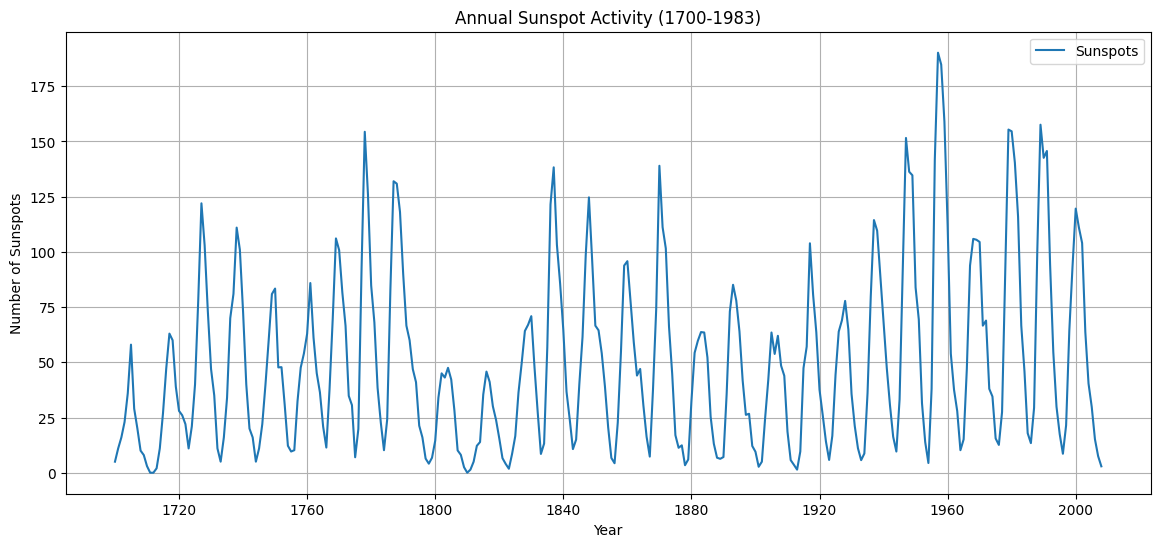

In [7]:
# Plot the sunspots time series
plt.figure(figsize=(14, 6))
plt.plot(sunspots.index, sunspots['Sunspots'], label='Sunspots')
plt.title('Annual Sunspot Activity (1700-1983)')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def check_stationarity(series, significance_level=0.05):
    """
    Performs the Augmented Dickey-Fuller test to check stationarity.

    Args:
        series (pd.Series): Time series data.
        significance_level (float): Significance level for the test.

    Returns:
        None: Prints the test results.
    """
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] < significance_level:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Check stationarity
print("Checking stationarity...")
check_stationarity(sunspots['Sunspots'], significance_level=0.05)

Checking stationarity...
ADF Statistic: -2.8377807249381943
p-value: 0.053076421728120673
Critical Value (1%): -3.4523371197407404
Critical Value (5%): -2.871222860740741
Critical Value (10%): -2.571929211111111
The series is non-stationary.


# Preprocessing

In [9]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate split indices
n_total = len(sunspots)
n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)
n_test = n_total - n_train - n_val

# Split the data
train_data = sunspots.iloc[:n_train]
val_data = sunspots.iloc[n_train:n_train + n_val]
test_data = sunspots.iloc[n_train + n_val:]

print(f"Total samples: {n_total}")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Total samples: 309
Training samples: 216
Validation samples: 46
Test samples: 47


In [10]:
# Add 'Year' as a feature
def add_time_features(df):
    """
    Adds time-based features to the dataframe.

    Args:
        df (pd.DataFrame): Dataframe with datetime index.

    Returns:
        pd.DataFrame: Dataframe with added time features.
    """
    df = df.copy()
    df['Year'] = df.index.year
    return df

# Apply to all splits
train_data = add_time_features(train_data)
val_data = add_time_features(val_data)
test_data = add_time_features(test_data)

# Display the data
print("Preview of the training data with time feature:")
display(train_data.head())

Preview of the training data with time feature:


,Sunspots,Year
Date,,
1700-01-01,5.0,1700
1701-01-01,11.0,1701
1702-01-01,16.0,1702
1703-01-01,23.0,1703
1704-01-01,36.0,1704


In [11]:
# Add cyclical features for 'Year'
def add_cyclical_features(df, column='Year', max_value=None):
    """
    Adds cyclical features (sine and cosine) for a specified column.

    Args:
        df (pd.DataFrame): Dataframe containing the column.
        column (str): Column name to transform.
        max_value (int): Maximum value of the column for scaling.

    Returns:
        pd.DataFrame: Dataframe with added cyclical features.
    """
    df = df.copy()
    if max_value is None:
        max_value = df[column].max()
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_value)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_value)
    return df

# Apply cyclical transformation
train_data = add_cyclical_features(train_data)
val_data = add_cyclical_features(val_data)
test_data = add_cyclical_features(test_data)

# Display the data
print("Preview of the training data with cyclical features:")
display(train_data.head())

Preview of the training data with cyclical features:


,Sunspots,Year,Year_sin,Year_cos
Date,,,,
1700-01-01,5.0,1700,-0.648356,0.761337
1701-01-01,11.0,1701,-0.645854,0.763461
1702-01-01,16.0,1702,-0.643346,0.765576
1703-01-01,23.0,1703,-0.640831,0.767682
1704-01-01,36.0,1704,-0.638308,0.769781


In [12]:
# Initialize scaler
scaler = MinMaxScaler()
year_scaler = MinMaxScaler()

# Fit the scalers
scaler.fit(train_data[['Sunspots']])
year_scaler.fit(train_data[['Year']])

# Create copies of the data splits
train_data_scaled = train_data.copy()
val_data_scaled = val_data.copy()
test_data_scaled = test_data.copy()

# Transform 'Sunspots' in all splits
train_data_scaled['Sunspots'] = scaler.transform(train_data[['Sunspots']])
val_data_scaled['Sunspots'] = scaler.transform(val_data[['Sunspots']])
test_data_scaled['Sunspots'] = scaler.transform(test_data[['Sunspots']])

# Transform 'Year' in all splits
train_data_scaled['Year'] = year_scaler.transform(train_data[['Year']])
val_data_scaled['Year'] = year_scaler.transform(val_data[['Year']])
test_data_scaled['Year'] = year_scaler.transform(test_data[['Year']])

# Verify scaling
print("Training Sunspots scaled:")
display(train_data_scaled[['Sunspots', 'Year']].describe())

Training Sunspots scaled:


,Sunspots,Year
count,216.000000,216.000000
mean,0.277850,0.500000
std,0.222000,0.290688
min,0.000000,0.000000
25%,0.083711,0.250000
50%,0.236723,0.500000
75%,0.411593,0.750000
max,1.000000,1.000000


In [13]:
def create_sequences(data, window_size):
    """
    Creates input sequences and corresponding targets using a sliding window approach.

    Args:
        data (pd.DataFrame): Dataframe with features and scaled 'Sunspots'.
        window_size (int): Number of past time steps to use for prediction.

    Returns:
        sequences (np.ndarray): Input sequences of shape (n_samples, window_size, n_features).
        targets (np.ndarray): Corresponding targets of shape (n_samples, 1).
    """
    sequences = []
    targets = []
    feature_columns = ['Sunspots', 'Year', 'Year_sin', 'Year_cos']  # Features to include
    for i in range(len(data) - window_size):
        seq = data[feature_columns].iloc[i:i+window_size].values
        target = data['Sunspots'].iloc[i+window_size]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [14]:
# Define window size
window_size = 24  # Using past 24 years to predict the next year

# Create sequences and targets for each split
X_train, y_train = create_sequences(train_data_scaled, window_size)
X_val, y_val = create_sequences(val_data_scaled, window_size)
X_test, y_test = create_sequences(test_data_scaled, window_size)

# Verify shapes
print(f"Training sequences shape: {X_train.shape}")   # Expected: (n_train_samples, 24, n_features)
print(f"Training targets shape: {y_train.shape}")     # Expected: (n_train_samples,)
print(f"Validation sequences shape: {X_val.shape}")   # Expected: (n_val_samples, 24, n_features)
print(f"Validation targets shape: {y_val.shape}")     # Expected: (n_val_samples,)
print(f"Test sequences shape: {X_test.shape}")        # Expected: (n_test_samples, 24, n_features)
print(f"Test targets shape: {y_test.shape}")          # Expected: (n_test_samples,)

Training sequences shape: (192, 24, 4)
Training targets shape: (192,)
Validation sequences shape: (22, 24, 4)
Validation targets shape: (22,)
Test sequences shape: (23, 24, 4)
Test targets shape: (23,)


In [15]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data.

    Args:
        sequences (np.ndarray): Input sequences of shape (n_samples, window_size, n_features).
        targets (np.ndarray): Corresponding targets of shape (n_samples,).
    """
    def __init__(self, sequences, targets):
        self.X = torch.tensor(sequences, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
def create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Creates DataLoaders for training, validation, and testing sets.

    Args:
        X_train (np.ndarray): Training input sequences.
        X_val (np.ndarray): Validation input sequences.
        X_test (np.ndarray): Testing input sequences.
        y_train (np.ndarray): Training targets.
        y_val (np.ndarray): Validation targets.
        y_test (np.ndarray): Testing targets.
        batch_size (int): Batch size for DataLoaders.

    Returns:
        train_loader (DataLoader): DataLoader for training set.
        val_loader (DataLoader): DataLoader for validation set.
        test_loader (DataLoader): DataLoader for testing set.
    """
    # Create Dataset instances
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [17]:
# Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(
    X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32
)

# Verify DataLoader outputs
for X_batch, y_batch in train_loader:
    print(f"Batch X shape: {X_batch.shape}")    # Expected: (batch_size, window_size, n_features)
    print(f"Batch y shape: {y_batch.shape}")    # Expected: (batch_size,)
    break  # Only need to check the first batch

Batch X shape: torch.Size([32, 24, 4])
Batch y shape: torch.Size([32])


# Model Definitions

## MLP

In [18]:
class MLPModel(nn.Module):
    """
    Multi-Layer Perceptron model for time series forecasting.

    Args:
        in_features (int): Number of input features (flattened window_size * n_features).
        hidden_dim (int): Number of neurons in hidden layers.
        num_layers (int): Number of hidden layers.
    """
    def __init__(self, in_features, hidden_dim, num_layers):
        super(MLPModel, self).__init__()

        layers = []

        # Implementation of layers before the last layer
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(in_features, hidden_dim))
            layers.append(nn.GELU())  # GELU activation
            in_features = hidden_dim

        # Implementation of the last layer
        layers.append(nn.Linear(hidden_dim, 1))

        # Constructing a Sequential neural network with the layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the MLPModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, n_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        # Flatten the input: (batch_size, window_size * n_features)
        x = x.view(x.size(0), -1)
        return self.network(x)

## FAN

In [19]:
class FANLayer(nn.Module):
    """
    Fourier Analysis Network Layer for capturing periodic components.

    Args:
        in_features (int): Number of input features.
        d_p (int): Dimension for periodic components.
        d_p_bar (int): Dimension for non-periodic components.
        activation (nn.Module): Activation function.
    """
    def __init__(self, in_features, d_p, d_p_bar, activation=nn.GELU()):
        super(FANLayer, self).__init__()
        self.Wp = nn.Parameter(torch.randn(in_features, d_p))
        self.Wp_bar = nn.Parameter(torch.randn(in_features, d_p_bar))
        self.Bp_bar = nn.Parameter(torch.zeros(d_p_bar))
        self.activation = activation

        # Initialize parameters
        nn.init.xavier_uniform_(self.Wp)
        nn.init.xavier_uniform_(self.Wp_bar)
        nn.init.zeros_(self.Bp_bar)

    def forward(self, x):
        """
        Forward pass of the FANLayer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Concatenated output tensor with periodic and non-periodic components.
        """
        cos_term = torch.cos(torch.matmul(x, self.Wp))
        sin_term = torch.sin(torch.matmul(x, self.Wp))
        non_periodic_term = self.activation(torch.matmul(x, self.Wp_bar) + self.Bp_bar)
        return torch.cat([cos_term, sin_term, non_periodic_term], dim=-1)

In [20]:
class FANModel(nn.Module):
    """
    Fourier Analysis Network model composed of multiple FANLayers.

    Args:
        in_features (int): Number of input features (flattened window_size * n_features).
        hidden_dim (int): Hidden dimension size.
        num_layers (int): Number of FAN layers.
        activation (nn.Module): Activation function.
    """
    def __init__(self, in_features, hidden_dim, num_layers, activation=nn.GELU()):
        super(FANModel, self).__init__()

        self.num_layers = num_layers
        self.layers = nn.ModuleList()

        # d_p set to a quarter of the hidden dimension
        d_p = hidden_dim // 4
        d_p_bar = hidden_dim

        # Implementation of layers before the final layer
        for _ in range(num_layers - 1):
            self.layers.append(FANLayer(in_features, d_p, d_p_bar, activation))
            # Updated after each layer to match the output dimension of the previous layer
            in_features = 2 * d_p + d_p_bar

        # Parameters for the final layer
        self.WL = nn.Parameter(torch.randn(in_features, 1))
        self.BL = nn.Parameter(torch.zeros(1))

        # Initialize parameters
        nn.init.xavier_uniform_(self.WL)
        nn.init.zeros_(self.BL)

    def forward(self, x):
        """
        Forward pass of the FANModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, n_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        # Flatten the input: (batch_size, window_size * n_features)
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        # Implementation of the final layer
        return torch.matmul(x, self.WL) + self.BL

## Gated FAN

In [21]:
class FANLayerGated(nn.Module):
    """
    Gated Fourier Analysis Network Layer for controlling information flow.

    Args:
        in_features (int): Number of input features.
        d_p (int): Dimension for periodic components.
        d_p_bar (int): Dimension for non-periodic components.
        activation (nn.Module): Activation function.
        gated (bool): Whether to apply gating.
    """
    def __init__(self, in_features, d_p, d_p_bar, activation=nn.GELU(), gated=True):
        super(FANLayerGated, self).__init__()
        self.Wp = nn.Parameter(torch.randn(in_features, d_p))
        self.Wp_bar = nn.Parameter(torch.randn(in_features, d_p_bar))
        self.Bp_bar = nn.Parameter(torch.zeros(d_p_bar))
        self.activation = activation

        # Initialize parameters
        nn.init.xavier_uniform_(self.Wp)
        nn.init.xavier_uniform_(self.Wp_bar)
        nn.init.zeros_(self.Bp_bar)

        if gated:
            # Initialize the gate parameter
            self.gate = nn.Parameter(torch.randn(1))
            nn.init.xavier_uniform_(self.gate.unsqueeze(0))

    def forward(self, x):
        """
        Forward pass of the FANLayerGated.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Concatenated and gated output tensor.
        """
        cos_term = torch.cos(torch.matmul(x, self.Wp))
        sin_term = torch.sin(torch.matmul(x, self.Wp))
        non_periodic_term = self.activation(torch.matmul(x, self.Wp_bar) + self.Bp_bar)

        if hasattr(self, 'gate'):
            gate = torch.sigmoid(self.gate)
            cos_term = gate * cos_term
            sin_term = gate * sin_term
            non_periodic_term = (1 - gate) * non_periodic_term

        return torch.cat([cos_term, sin_term, non_periodic_term], dim=-1)

In [22]:
class GFANModel(nn.Module):
    """
    Gated Fourier Analysis Network model composed of multiple FANLayerGated layers.

    Args:
        in_features (int): Number of input features (flattened window_size * n_features).
        hidden_dim (int): Hidden dimension size.
        num_layers (int): Number of FANLayerGated layers.
        activation (nn.Module): Activation function.
        gated (bool): Whether to apply gating.
    """
    def __init__(self, in_features, hidden_dim, num_layers, activation=nn.GELU(), gated=True):
        super(GFANModel, self).__init__()
        self.layers = nn.ModuleList()

        d_p = hidden_dim // 4
        d_p_bar = hidden_dim

        for _ in range(num_layers - 1):
            self.layers.append(FANLayerGated(in_features, d_p, d_p_bar, activation, gated))
            in_features = 2 * d_p + d_p_bar

        self.output_layer = nn.Linear(in_features, 1)

        # Initialize output layer parameters
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        """
        Forward pass of the GFANModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, n_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        # Flatten the input: (batch_size, window_size * n_features)
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

## Transformers

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): Dimension of the embeddings.
            dropout (float): Dropout rate.
            max_len (int): Maximum length of input sequences.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a long enough PEs matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))  # Shape: (d_model/2,)

        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd indices

        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)  # Register as buffer to avoid updating

    def forward(self, x):
        """
        Adds positional encoding to the input embeddings.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Tensor with positional encoding added.
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [24]:
class TransformerModel(nn.Module):
    """
    Transformer model for time series forecasting with positional encoding.

    Args:
        input_dim (int): Number of input features.
        model_dim (int): Dimension of the Transformer model.
        num_heads (int): Number of attention heads.
        num_layers (int): Number of Transformer encoder layers.
        dropout (float): Dropout rate.
        max_len (int): Maximum sequence length for positional encoding.
    """
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1, max_len=5000):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(d_model=model_dim, dropout=dropout, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_linear = nn.Linear(model_dim, 1)

    def forward(self, x):
        """
        Forward pass of the TransformerModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        # Linear transformation
        x = self.input_linear(x) * math.sqrt(self.model_dim)  # Shape: (B, L, model_dim)

        # Add positional encoding
        x = self.pos_encoder(x)  # Shape: (B, L, model_dim)

        # Prepare for Transformer: (L, B, model_dim)
        x = x.permute(1, 0, 2)

        # Transformer Encoder
        x = self.transformer_encoder(x)  # Shape: (L, B, model_dim)

        # Convert back to (B, L, model_dim)
        x = x.permute(1, 0, 2)

        # Aggregation: Use the last time step
        x = x[:, -1, :]  # Shape: (B, model_dim)

        # Final output layer
        x = self.output_linear(x)  # Shape: (B, 1)

        return x

In [25]:
class TransformerWithFANModel(nn.Module):
    """
    Transformer model with a FAN layer for time series forecasting, incorporating positional encoding.

    Args:
        input_dim (int): Number of input features.
        model_dim (int): Dimension of the Transformer model.
        num_heads (int): Number of attention heads.
        num_layers (int): Number of Transformer encoder layers.
        fan_hidden_dim (int): Hidden dimension size for FAN.
        fan_num_layers (int): Number of FAN layers.
        dropout (float): Dropout rate.
        max_len (int): Maximum sequence length for positional encoding.
    """
    def __init__(self, input_dim, model_dim, num_heads, num_layers, fan_hidden_dim, fan_num_layers, dropout=0.1, max_len=5000):
        super(TransformerWithFANModel, self).__init__()
        self.model_dim = model_dim
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(d_model=model_dim, dropout=dropout, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # FAN layer replaces the output linear layer
        self.fan = FANModel(model_dim, fan_hidden_dim, fan_num_layers)

    def forward(self, x):
        """
        Forward pass of the TransformerWithFANModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        # Linear transformation
        x = self.input_linear(x) * math.sqrt(self.model_dim)  # Shape: (B, L, model_dim)

        # Add positional encoding
        x = self.pos_encoder(x)  # Shape: (B, L, model_dim)

        # Prepare for Transformer: (L, B, model_dim)
        x = x.permute(1, 0, 2)

        # Transformer Encoder
        x = self.transformer_encoder(x)  # Shape: (L, B, model_dim)

        # Convert back to (B, L, model_dim)
        x = x.permute(1, 0, 2)

        # Aggregation: Use the last time step
        x = x[:, -1, :]  # Shape: (B, model_dim)

        # FAN Layer
        x = self.fan(x)  # Shape: (B, 1)

        return x

In [26]:
class TransformerWithGFANModel(nn.Module):
    """
    Transformer model with a Gated FAN layer for time series forecasting, incorporating positional encoding.

    Args:
        input_dim (int): Number of input features.
        model_dim (int): Dimension of the Transformer model.
        num_heads (int): Number of attention heads.
        num_layers (int): Number of Transformer encoder layers.
        fan_hidden_dim (int): Hidden dimension size for Gated FAN.
        fan_num_layers (int): Number of Gated FAN layers.
        dropout (float): Dropout rate.
        max_len (int): Maximum sequence length for positional encoding.
    """
    def __init__(self, input_dim, model_dim, num_heads, num_layers, fan_hidden_dim, fan_num_layers, dropout=0.1, max_len=5000):
        super(TransformerWithGFANModel, self).__init__()
        self.model_dim = model_dim
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(d_model=model_dim, dropout=dropout, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Gated FAN layer replaces the output linear layer
        self.fan_gated = GFANModel(model_dim, fan_hidden_dim, fan_num_layers, gated=True)

    def forward(self, x):
        """
        Forward pass of the TransformerWithGFANModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        # Linear transformation
        x = self.input_linear(x) * math.sqrt(self.model_dim)  # Shape: (B, L, model_dim)

        # Add positional encoding
        x = self.pos_encoder(x)  # Shape: (B, L, model_dim)

        # Prepare for Transformer: (L, B, model_dim)
        x = x.permute(1, 0, 2)

        # Transformer Encoder
        x = self.transformer_encoder(x)  # Shape: (L, B, model_dim)

        # Convert back to (B, L, model_dim)
        x = x.permute(1, 0, 2)

        # Aggregation: Use the last time step
        x = x[:, -1, :]  # Shape: (B, model_dim)

        # Gated FAN Layer
        x = self.fan_gated(x)  # Shape: (B, 1)

        return x

## LSTM

In [27]:
class LSTMModel(nn.Module):
    """
    LSTM model for time series forecasting.

    Args:
        input_dim (int): Number of input features.
        hidden_dim (int): Hidden dimension size.
        num_layers (int): Number of LSTM layers.
        dropout (float): Dropout rate between LSTM layers.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        # Define the output layer
        self.output_linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        Forward pass of the LSTMModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, window_size, hidden_dim)

        # Decode the hidden state of the last time step
        out = self.output_linear(out[:, -1, :])  # (batch_size, 1)
        return out

## GRU

In [28]:
class GRUModel(nn.Module):
    """
    GRU model for time series forecasting.

    Args:
        input_dim (int): Number of input features.
        hidden_dim (int): Hidden dimension size.
        num_layers (int): Number of GRU layers.
        dropout (float): Dropout rate between GRU layers.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.1):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the GRU layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        # Define the output layer
        self.output_linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        Forward pass of the GRUModel.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: (batch_size, window_size, hidden_dim)

        # Decode the hidden state of the last time step
        out = self.output_linear(out[:, -1, :])  # (batch_size, 1)
        return out

# Model Initialization

In [29]:
# Define parameters
window_size = 24  # Number of past time steps
n_features = 4    # ['Sunspots', 'Year', 'Year_cos', 'Year_sin']

# Initialize a dictionary to store models and their configurations
model_configs = {
    'MLPModel': {
        'model': None,
        'params': {
            'in_features': window_size * n_features,  # 24 * 4 = 96
            'hidden_dim': 64,
            'num_layers': 3
        }
    },
    'FANModel': {
        'model': None,
        'params': {
            'in_features': window_size * n_features,  # 24 * 4 = 96
            'hidden_dim': 64,
            'num_layers': 3
        }
    },
    'GFANModel': {
        'model': None,
        'params': {
            'in_features': window_size * n_features,  # 24 * 4 = 96
            'hidden_dim': 64,
            'num_layers': 3,
            'gated': True
        }
    },
    'TransformerModel': {
        'model': None,
        'params': {
            'input_dim': n_features,
            'model_dim': 64,
            'num_heads': 4,
            'num_layers': 2,
            'dropout': 0.1
        }
    },
    'TransformerWithFANModel': {
        'model': None,
        'params': {
            'input_dim': n_features,
            'model_dim': 64,
            'num_heads': 4,
            'num_layers': 2,
            'fan_hidden_dim': 32,
            'fan_num_layers': 2,
            'dropout': 0.1
        }
    },
    'TransformerWithGFANModel': {
        'model': None,
        'params': {
            'input_dim': n_features,
            'model_dim': 64,
            'num_heads': 4,
            'num_layers': 2,
            'fan_hidden_dim': 32,
            'fan_num_layers': 2,
            'dropout': 0.1
        }
    },
    'LSTMModel': {
        'model': None,
        'params': {
            'input_dim': n_features,
            'hidden_dim': 64,
            'num_layers': 2,
            'dropout': 0.1
        }
    },
    'GRUModel': {
        'model': None,
        'params': {
            'input_dim': n_features,
            'hidden_dim': 64,
            'num_layers': 2,
            'dropout': 0.1
        }
    }
}

In [30]:
# Initialize all models
print("--- Initializing All Models ---")
for name, config in model_configs.items():
    if name == 'MLPModel':
        model = MLPModel(**config['params']).to(device)
    elif name == 'FANModel':
        model = FANModel(**config['params']).to(device)
    elif name == 'GFANModel':
        model = GFANModel(**config['params']).to(device)
    elif name == 'TransformerModel':
        model = TransformerModel(**config['params']).to(device)
    elif name == 'TransformerWithFANModel':
        model = TransformerWithFANModel(**config['params']).to(device)
    elif name == 'TransformerWithGFANModel':
        model = TransformerWithGFANModel(**config['params']).to(device)
    elif name == 'LSTMModel':
        model = LSTMModel(**config['params']).to(device)
    elif name == 'GRUModel':
        model = GRUModel(**config['params']).to(device)
    else:
        raise ValueError(f"Unknown model name: {name}")
    config['model'] = model
    print(f"Initialized {name}.")

--- Initializing All Models ---
Initialized MLPModel.
Initialized FANModel.
Initialized GFANModel.
Initialized TransformerModel.
Initialized TransformerWithFANModel.
Initialized TransformerWithGFANModel.
Initialized LSTMModel.
Initialized GRUModel.


# Model Training

In [31]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        patience (int): How long to wait after last time validation loss improved.
        verbose (bool): If True, prints a message for each validation loss improvement.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        path (str): Path for the checkpoint to be saved to.
    """
    def __init__(self, patience=10, verbose=False, delta=0.0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = np.Inf

    def __call__(self, val_loss, model, model_name):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_name)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_name)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_name):
        """
        Saves model when validation loss decreases.

        Args:
            val_loss (float): Current validation loss.
            model (nn.Module): Model to save.
            model_name (str): Name of the model.
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'best_model_{model_name}.pt')
        self.best_loss = val_loss

In [32]:
def train_model(model, train_loader, val_loader, epochs, lr, model_name, device, early_stopping=None, max_grad_norm=1.0, print_freq=1):
    """
    Trains the given model and validates it with optional early stopping and gradient clipping.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        epochs (int): Number of training epochs.
        lr (float): Learning rate.
        model_name (str): Name of the model (for logging purposes).
        device (torch.device): Device to run the training on.
        early_stopping (EarlyStopping, optional): EarlyStopping instance.
        max_grad_norm (float): Maximum norm for gradient clipping.
        print_freq (int): Frequency of printing losses (in epochs).

    Returns:
        train_losses (list): Training loss per epoch.
        val_losses (list): Validation loss per epoch.
    """
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
        # Training Phase
        model.train()
        epoch_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()

            # Gradient Clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            epoch_train_loss += loss.item() * X_batch.size(0)

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                epoch_val_loss += loss.item() * X_batch.size(0)

        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Early Stopping
        if early_stopping:
            early_stopping(epoch_val_loss, model, model_name)
            if early_stopping.early_stop:
                print(f"Early stopping triggered for {model_name} at epoch {epoch}")
                break

        # Print losses at specified frequency
        if epoch % print_freq == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs} - {model_name} Training Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

    return train_losses, val_losses

In [33]:
def save_model(model, path):
    """
    Saves the trained model to the specified path.

    Args:
        model (nn.Module): Trained model.
        path (str): File path to save the model.
    """
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [34]:
def load_model(model, path, device):
    """
    Loads the model weights from the specified path.

    Args:
        model (nn.Module): Model instance to load weights into.
        path (str): File path from which to load the model.
        device (torch.device): Device to map the model to.
    """
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {path}")

In [35]:
# Initialize Early Stopping for all models
early_stopping_configs = {}
for name in model_configs.keys():
    early_stopping_configs[name] = EarlyStopping(patience=20, verbose=False, delta=0.0001, path=f'best_model_{name}.pt')

In [36]:
# Train all models
print("--- Training All Models ---")
epochs = 200
learning_rate = 0.001
max_grad_norm = 1.0  # Maximum norm for gradient clipping
print_freq = 1       # Print losses every epoch by default

for name, config in model_configs.items():
    print(f"\n--- Training {name} ---")
    model = config['model']
    es = early_stopping_configs[name]
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=learning_rate,
        model_name=name,
        device=device,
        early_stopping=es,
        max_grad_norm=max_grad_norm,
        print_freq=print_freq
    )

--- Training All Models ---

--- Training MLPModel ---


Training MLPModel:   4%|▍         | 9/200 [00:00<00:06, 27.77it/s]

Epoch 1/200 - MLPModel Training Loss: 0.138595, Validation Loss: 0.227824
Epoch 2/200 - MLPModel Training Loss: 0.060316, Validation Loss: 0.135020
Epoch 3/200 - MLPModel Training Loss: 0.053517, Validation Loss: 0.166329
Epoch 4/200 - MLPModel Training Loss: 0.046355, Validation Loss: 0.213985
Epoch 5/200 - MLPModel Training Loss: 0.047350, Validation Loss: 0.189791
Epoch 6/200 - MLPModel Training Loss: 0.043121, Validation Loss: 0.160208
Epoch 7/200 - MLPModel Training Loss: 0.041140, Validation Loss: 0.167181
Epoch 8/200 - MLPModel Training Loss: 0.038386, Validation Loss: 0.179536
Epoch 9/200 - MLPModel Training Loss: 0.035657, Validation Loss: 0.155878
Epoch 10/200 - MLPModel Training Loss: 0.032660, Validation Loss: 0.142052
Epoch 11/200 - MLPModel Training Loss: 0.029919, Validation Loss: 0.134508
Epoch 12/200 - MLPModel Training Loss: 0.027063, Validation Loss: 0.110651
Epoch 13/200 - MLPModel Training Loss: 0.025306, Validation Loss: 0.101467
Epoch 14/200 - MLPModel Training L

Training MLPModel:  12%|█▏        | 23/200 [00:00<00:03, 47.86it/s]

Epoch 15/200 - MLPModel Training Loss: 0.023113, Validation Loss: 0.083388
Epoch 16/200 - MLPModel Training Loss: 0.022329, Validation Loss: 0.079184
Epoch 17/200 - MLPModel Training Loss: 0.021482, Validation Loss: 0.074488
Epoch 18/200 - MLPModel Training Loss: 0.020694, Validation Loss: 0.071408
Epoch 19/200 - MLPModel Training Loss: 0.019905, Validation Loss: 0.066676
Epoch 20/200 - MLPModel Training Loss: 0.019221, Validation Loss: 0.063422
Epoch 21/200 - MLPModel Training Loss: 0.018580, Validation Loss: 0.059829
Epoch 22/200 - MLPModel Training Loss: 0.017986, Validation Loss: 0.056315
Epoch 23/200 - MLPModel Training Loss: 0.017446, Validation Loss: 0.053230
Epoch 24/200 - MLPModel Training Loss: 0.016939, Validation Loss: 0.050184
Epoch 25/200 - MLPModel Training Loss: 0.016476, Validation Loss: 0.047471
Epoch 26/200 - MLPModel Training Loss: 0.016059, Validation Loss: 0.045161
Epoch 27/200 - MLPModel Training Loss: 0.015677, Validation Loss: 0.043149


Training MLPModel:  18%|█▊        | 37/200 [00:00<00:02, 56.57it/s]

Epoch 28/200 - MLPModel Training Loss: 0.015316, Validation Loss: 0.041303
Epoch 29/200 - MLPModel Training Loss: 0.014973, Validation Loss: 0.039521
Epoch 30/200 - MLPModel Training Loss: 0.014662, Validation Loss: 0.038038
Epoch 31/200 - MLPModel Training Loss: 0.014388, Validation Loss: 0.037145
Epoch 32/200 - MLPModel Training Loss: 0.014115, Validation Loss: 0.036286
Epoch 33/200 - MLPModel Training Loss: 0.013782, Validation Loss: 0.034561
Epoch 34/200 - MLPModel Training Loss: 0.013514, Validation Loss: 0.033040
Epoch 35/200 - MLPModel Training Loss: 0.013395, Validation Loss: 0.033941
Epoch 36/200 - MLPModel Training Loss: 0.013407, Validation Loss: 0.035719
Epoch 37/200 - MLPModel Training Loss: 0.012770, Validation Loss: 0.031523
Epoch 38/200 - MLPModel Training Loss: 0.012808, Validation Loss: 0.026912
Epoch 39/200 - MLPModel Training Loss: 0.013114, Validation Loss: 0.030518
Epoch 40/200 - MLPModel Training Loss: 0.017335, Validation Loss: 0.053842
Epoch 41/200 - MLPModel T

Training MLPModel:  26%|██▌       | 51/200 [00:01<00:02, 60.68it/s]

Epoch 42/200 - MLPModel Training Loss: 0.030105, Validation Loss: 0.037481
Epoch 43/200 - MLPModel Training Loss: 0.020904, Validation Loss: 0.050396
Epoch 44/200 - MLPModel Training Loss: 0.024261, Validation Loss: 0.028620
Epoch 45/200 - MLPModel Training Loss: 0.013444, Validation Loss: 0.049338
Epoch 46/200 - MLPModel Training Loss: 0.013732, Validation Loss: 0.035454
Epoch 47/200 - MLPModel Training Loss: 0.014452, Validation Loss: 0.050409
Epoch 48/200 - MLPModel Training Loss: 0.012049, Validation Loss: 0.033893
Epoch 49/200 - MLPModel Training Loss: 0.011976, Validation Loss: 0.036074
Epoch 50/200 - MLPModel Training Loss: 0.011894, Validation Loss: 0.032130
Epoch 51/200 - MLPModel Training Loss: 0.011486, Validation Loss: 0.032548
Epoch 52/200 - MLPModel Training Loss: 0.011390, Validation Loss: 0.033170
Epoch 53/200 - MLPModel Training Loss: 0.011115, Validation Loss: 0.030696
Epoch 54/200 - MLPModel Training Loss: 0.010961, Validation Loss: 0.030050
Epoch 55/200 - MLPModel T

Training MLPModel:  28%|██▊       | 57/200 [00:01<00:02, 49.37it/s]


Epoch 56/200 - MLPModel Training Loss: 0.010683, Validation Loss: 0.028832
Epoch 57/200 - MLPModel Training Loss: 0.010575, Validation Loss: 0.028557
Early stopping triggered for MLPModel at epoch 58

--- Training FANModel ---


Training FANModel:   2%|▏         | 4/200 [00:00<00:05, 39.06it/s]

Epoch 1/200 - FANModel Training Loss: 0.187411, Validation Loss: 0.509856
Epoch 2/200 - FANModel Training Loss: 0.273103, Validation Loss: 0.801760
Epoch 3/200 - FANModel Training Loss: 0.052472, Validation Loss: 0.105716
Epoch 4/200 - FANModel Training Loss: 0.048798, Validation Loss: 0.109606
Epoch 5/200 - FANModel Training Loss: 0.162677, Validation Loss: 0.066461
Epoch 6/200 - FANModel Training Loss: 0.105689, Validation Loss: 0.105501
Epoch 7/200 - FANModel Training Loss: 0.031106, Validation Loss: 0.087332


Training FANModel:   5%|▌         | 10/200 [00:00<00:04, 45.92it/s]

Epoch 8/200 - FANModel Training Loss: 0.040806, Validation Loss: 0.050836
Epoch 9/200 - FANModel Training Loss: 0.021509, Validation Loss: 0.084781
Epoch 10/200 - FANModel Training Loss: 0.019307, Validation Loss: 0.061186
Epoch 11/200 - FANModel Training Loss: 0.018551, Validation Loss: 0.053751


Training FANModel:   8%|▊         | 15/200 [00:00<00:04, 45.54it/s]

Epoch 12/200 - FANModel Training Loss: 0.020270, Validation Loss: 0.079023
Epoch 13/200 - FANModel Training Loss: 0.021169, Validation Loss: 0.049536
Epoch 14/200 - FANModel Training Loss: 0.056410, Validation Loss: 0.082260
Epoch 15/200 - FANModel Training Loss: 0.033740, Validation Loss: 0.051328
Epoch 16/200 - FANModel Training Loss: 0.030733, Validation Loss: 0.056910
Epoch 17/200 - FANModel Training Loss: 0.044621, Validation Loss: 0.051803


Training FANModel:  10%|█         | 20/200 [00:00<00:04, 44.78it/s]

Epoch 18/200 - FANModel Training Loss: 0.026790, Validation Loss: 0.061531
Epoch 19/200 - FANModel Training Loss: 0.026804, Validation Loss: 0.068934
Epoch 20/200 - FANModel Training Loss: 0.022955, Validation Loss: 0.069608


Training FANModel:  12%|█▎        | 25/200 [00:00<00:03, 45.08it/s]

Epoch 21/200 - FANModel Training Loss: 0.021959, Validation Loss: 0.048572
Epoch 22/200 - FANModel Training Loss: 0.018804, Validation Loss: 0.069264
Epoch 23/200 - FANModel Training Loss: 0.015614, Validation Loss: 0.054092
Epoch 24/200 - FANModel Training Loss: 0.014461, Validation Loss: 0.054116
Epoch 25/200 - FANModel Training Loss: 0.014391, Validation Loss: 0.054361
Epoch 26/200 - FANModel Training Loss: 0.016798, Validation Loss: 0.050640
Epoch 27/200 - FANModel Training Loss: 0.016014, Validation Loss: 0.050574


Training FANModel:  15%|█▌        | 30/200 [00:00<00:03, 45.96it/s]

Epoch 28/200 - FANModel Training Loss: 0.016178, Validation Loss: 0.052524
Epoch 29/200 - FANModel Training Loss: 0.040697, Validation Loss: 0.045461
Epoch 30/200 - FANModel Training Loss: 0.016282, Validation Loss: 0.074247


Training FANModel:  18%|█▊        | 35/200 [00:00<00:03, 43.80it/s]

Epoch 31/200 - FANModel Training Loss: 0.014458, Validation Loss: 0.053505
Epoch 32/200 - FANModel Training Loss: 0.016875, Validation Loss: 0.051402
Epoch 33/200 - FANModel Training Loss: 0.019187, Validation Loss: 0.043550
Epoch 34/200 - FANModel Training Loss: 0.029170, Validation Loss: 0.042011
Epoch 35/200 - FANModel Training Loss: 0.020559, Validation Loss: 0.072733
Epoch 36/200 - FANModel Training Loss: 0.015030, Validation Loss: 0.047528


Training FANModel:  20%|██        | 40/200 [00:00<00:03, 45.11it/s]

Epoch 37/200 - FANModel Training Loss: 0.014838, Validation Loss: 0.054021
Epoch 38/200 - FANModel Training Loss: 0.015502, Validation Loss: 0.055590
Epoch 39/200 - FANModel Training Loss: 0.020616, Validation Loss: 0.046268
Epoch 40/200 - FANModel Training Loss: 0.030808, Validation Loss: 0.087962


Training FANModel:  23%|██▎       | 46/200 [00:01<00:03, 48.05it/s]

Epoch 41/200 - FANModel Training Loss: 0.014315, Validation Loss: 0.045568
Epoch 42/200 - FANModel Training Loss: 0.014489, Validation Loss: 0.058827
Epoch 43/200 - FANModel Training Loss: 0.018944, Validation Loss: 0.049457
Epoch 44/200 - FANModel Training Loss: 0.013016, Validation Loss: 0.061175
Epoch 45/200 - FANModel Training Loss: 0.013151, Validation Loss: 0.054404
Epoch 46/200 - FANModel Training Loss: 0.017900, Validation Loss: 0.045874
Epoch 47/200 - FANModel Training Loss: 0.013015, Validation Loss: 0.057007
Epoch 48/200 - FANModel Training Loss: 0.012453, Validation Loss: 0.052524
Epoch 49/200 - FANModel Training Loss: 0.017927, Validation Loss: 0.045444
Epoch 50/200 - FANModel Training Loss: 0.014040, Validation Loss: 0.057123
Epoch 51/200 - FANModel Training Loss: 0.012981, Validation Loss: 0.053006


Training FANModel:  26%|██▋       | 53/200 [00:01<00:03, 45.83it/s]


Epoch 52/200 - FANModel Training Loss: 0.020950, Validation Loss: 0.043366
Epoch 53/200 - FANModel Training Loss: 0.017088, Validation Loss: 0.070460
Early stopping triggered for FANModel at epoch 54

--- Training GFANModel ---


Training GFANModel:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 - GFANModel Training Loss: 0.082404, Validation Loss: 0.199865
Epoch 2/200 - GFANModel Training Loss: 0.062843, Validation Loss: 0.319862


Training GFANModel:   2%|▏         | 4/200 [00:00<00:05, 34.77it/s]

Epoch 3/200 - GFANModel Training Loss: 0.046021, Validation Loss: 0.201348
Epoch 4/200 - GFANModel Training Loss: 0.042227, Validation Loss: 0.163837
Epoch 5/200 - GFANModel Training Loss: 0.036724, Validation Loss: 0.152027


Training GFANModel:   4%|▍         | 8/200 [00:00<00:05, 37.53it/s]

Epoch 6/200 - GFANModel Training Loss: 0.033952, Validation Loss: 0.119543
Epoch 7/200 - GFANModel Training Loss: 0.030045, Validation Loss: 0.126284
Epoch 8/200 - GFANModel Training Loss: 0.027707, Validation Loss: 0.110380
Epoch 9/200 - GFANModel Training Loss: 0.026023, Validation Loss: 0.107521
Epoch 10/200 - GFANModel Training Loss: 0.024411, Validation Loss: 0.093650
Epoch 11/200 - GFANModel Training Loss: 0.023270, Validation Loss: 0.088198


Training GFANModel:   6%|▋         | 13/200 [00:00<00:04, 38.96it/s]

Epoch 12/200 - GFANModel Training Loss: 0.022153, Validation Loss: 0.081799
Epoch 13/200 - GFANModel Training Loss: 0.021077, Validation Loss: 0.079238
Epoch 14/200 - GFANModel Training Loss: 0.020034, Validation Loss: 0.075222


Training GFANModel:   8%|▊         | 17/200 [00:00<00:04, 38.11it/s]

Epoch 15/200 - GFANModel Training Loss: 0.019008, Validation Loss: 0.070394
Epoch 16/200 - GFANModel Training Loss: 0.018081, Validation Loss: 0.066627
Epoch 17/200 - GFANModel Training Loss: 0.017227, Validation Loss: 0.062941
Epoch 18/200 - GFANModel Training Loss: 0.016455, Validation Loss: 0.059326


Training GFANModel:  10%|█         | 21/200 [00:00<00:05, 34.47it/s]

Epoch 19/200 - GFANModel Training Loss: 0.015764, Validation Loss: 0.056165
Epoch 20/200 - GFANModel Training Loss: 0.015138, Validation Loss: 0.053255
Epoch 21/200 - GFANModel Training Loss: 0.014538, Validation Loss: 0.049802
Epoch 22/200 - GFANModel Training Loss: 0.014054, Validation Loss: 0.046817
Epoch 23/200 - GFANModel Training Loss: 0.013728, Validation Loss: 0.046577
Epoch 24/200 - GFANModel Training Loss: 0.013467, Validation Loss: 0.046132


Training GFANModel:  12%|█▎        | 25/200 [00:00<00:05, 34.96it/s]

Epoch 25/200 - GFANModel Training Loss: 0.012733, Validation Loss: 0.039631
Epoch 26/200 - GFANModel Training Loss: 0.012943, Validation Loss: 0.035347
Epoch 27/200 - GFANModel Training Loss: 0.013278, Validation Loss: 0.045391
Epoch 28/200 - GFANModel Training Loss: 0.017517, Validation Loss: 0.058310
Epoch 29/200 - GFANModel Training Loss: 0.014509, Validation Loss: 0.035043


Training GFANModel:  15%|█▌        | 30/200 [00:00<00:04, 36.88it/s]

Epoch 30/200 - GFANModel Training Loss: 0.040394, Validation Loss: 0.069513
Epoch 31/200 - GFANModel Training Loss: 0.014178, Validation Loss: 0.036390
Epoch 32/200 - GFANModel Training Loss: 0.014237, Validation Loss: 0.036111
Epoch 33/200 - GFANModel Training Loss: 0.013696, Validation Loss: 0.041774
Epoch 34/200 - GFANModel Training Loss: 0.012537, Validation Loss: 0.042130


Training GFANModel:  18%|█▊        | 35/200 [00:00<00:04, 38.81it/s]

Epoch 35/200 - GFANModel Training Loss: 0.014042, Validation Loss: 0.036518
Epoch 36/200 - GFANModel Training Loss: 0.011970, Validation Loss: 0.036504
Epoch 37/200 - GFANModel Training Loss: 0.014370, Validation Loss: 0.041071
Epoch 38/200 - GFANModel Training Loss: 0.012867, Validation Loss: 0.037743


Training GFANModel:  20%|█▉        | 39/200 [00:01<00:04, 37.72it/s]

Epoch 39/200 - GFANModel Training Loss: 0.013879, Validation Loss: 0.033896
Epoch 40/200 - GFANModel Training Loss: 0.014532, Validation Loss: 0.038595
Epoch 41/200 - GFANModel Training Loss: 0.012652, Validation Loss: 0.040776
Epoch 42/200 - GFANModel Training Loss: 0.015966, Validation Loss: 0.032449


Training GFANModel:  22%|██▏       | 43/200 [00:01<00:04, 38.14it/s]

Epoch 43/200 - GFANModel Training Loss: 0.011610, Validation Loss: 0.036059
Epoch 44/200 - GFANModel Training Loss: 0.013860, Validation Loss: 0.042593
Epoch 45/200 - GFANModel Training Loss: 0.011870, Validation Loss: 0.034165
Epoch 46/200 - GFANModel Training Loss: 0.011591, Validation Loss: 0.033025


Training GFANModel:  24%|██▎       | 47/200 [00:01<00:04, 37.50it/s]

Epoch 47/200 - GFANModel Training Loss: 0.011669, Validation Loss: 0.038009
Epoch 48/200 - GFANModel Training Loss: 0.010569, Validation Loss: 0.036613
Epoch 49/200 - GFANModel Training Loss: 0.011406, Validation Loss: 0.032512
Epoch 50/200 - GFANModel Training Loss: 0.010187, Validation Loss: 0.033331


Training GFANModel:  26%|██▌       | 51/200 [00:01<00:03, 37.98it/s]

Epoch 51/200 - GFANModel Training Loss: 0.011056, Validation Loss: 0.035856
Epoch 52/200 - GFANModel Training Loss: 0.010607, Validation Loss: 0.034121
Epoch 53/200 - GFANModel Training Loss: 0.010862, Validation Loss: 0.031797
Epoch 54/200 - GFANModel Training Loss: 0.011463, Validation Loss: 0.032469


Training GFANModel:  28%|██▊       | 55/200 [00:01<00:03, 37.69it/s]

Epoch 55/200 - GFANModel Training Loss: 0.010942, Validation Loss: 0.036098
Epoch 56/200 - GFANModel Training Loss: 0.014389, Validation Loss: 0.033066
Epoch 57/200 - GFANModel Training Loss: 0.011287, Validation Loss: 0.030814
Epoch 58/200 - GFANModel Training Loss: 0.018750, Validation Loss: 0.042373


Training GFANModel:  30%|██▉       | 59/200 [00:01<00:03, 37.97it/s]

Epoch 59/200 - GFANModel Training Loss: 0.012591, Validation Loss: 0.033255
Epoch 60/200 - GFANModel Training Loss: 0.015370, Validation Loss: 0.029048
Epoch 61/200 - GFANModel Training Loss: 0.012278, Validation Loss: 0.041712
Epoch 62/200 - GFANModel Training Loss: 0.009999, Validation Loss: 0.036453
Epoch 63/200 - GFANModel Training Loss: 0.010168, Validation Loss: 0.030681


Training GFANModel:  32%|███▏      | 64/200 [00:01<00:03, 38.82it/s]

Epoch 64/200 - GFANModel Training Loss: 0.009292, Validation Loss: 0.034274
Epoch 65/200 - GFANModel Training Loss: 0.009201, Validation Loss: 0.034151
Epoch 66/200 - GFANModel Training Loss: 0.009090, Validation Loss: 0.031743
Epoch 67/200 - GFANModel Training Loss: 0.008972, Validation Loss: 0.031867


Training GFANModel:  34%|███▍      | 68/200 [00:01<00:03, 38.57it/s]

Epoch 68/200 - GFANModel Training Loss: 0.008910, Validation Loss: 0.031979
Epoch 69/200 - GFANModel Training Loss: 0.008851, Validation Loss: 0.031377
Epoch 70/200 - GFANModel Training Loss: 0.008774, Validation Loss: 0.031021


Training GFANModel:  36%|███▌      | 72/200 [00:01<00:03, 36.36it/s]

Epoch 71/200 - GFANModel Training Loss: 0.008719, Validation Loss: 0.031016
Epoch 72/200 - GFANModel Training Loss: 0.008671, Validation Loss: 0.031099
Epoch 73/200 - GFANModel Training Loss: 0.008644, Validation Loss: 0.030822
Epoch 74/200 - GFANModel Training Loss: 0.008553, Validation Loss: 0.030229
Epoch 75/200 - GFANModel Training Loss: 0.008547, Validation Loss: 0.030455


Training GFANModel:  38%|███▊      | 76/200 [00:02<00:03, 36.94it/s]

Epoch 76/200 - GFANModel Training Loss: 0.008593, Validation Loss: 0.031609
Epoch 77/200 - GFANModel Training Loss: 0.008611, Validation Loss: 0.030682
Epoch 78/200 - GFANModel Training Loss: 0.008689, Validation Loss: 0.028371


Training GFANModel:  40%|████      | 80/200 [00:02<00:03, 36.85it/s]

Epoch 79/200 - GFANModel Training Loss: 0.008827, Validation Loss: 0.030317
Epoch 80/200 - GFANModel Training Loss: 0.010563, Validation Loss: 0.037417
Epoch 81/200 - GFANModel Training Loss: 0.010127, Validation Loss: 0.029991
Epoch 82/200 - GFANModel Training Loss: 0.017791, Validation Loss: 0.028326
Epoch 83/200 - GFANModel Training Loss: 0.013372, Validation Loss: 0.038827


Training GFANModel:  42%|████▏     | 84/200 [00:02<00:03, 36.60it/s]

Epoch 84/200 - GFANModel Training Loss: 0.035939, Validation Loss: 0.029939
Epoch 85/200 - GFANModel Training Loss: 0.008867, Validation Loss: 0.043126
Epoch 86/200 - GFANModel Training Loss: 0.008689, Validation Loss: 0.037345


Training GFANModel:  44%|████▍     | 88/200 [00:02<00:03, 36.74it/s]

Epoch 87/200 - GFANModel Training Loss: 0.010091, Validation Loss: 0.033102
Epoch 88/200 - GFANModel Training Loss: 0.009573, Validation Loss: 0.036076
Epoch 89/200 - GFANModel Training Loss: 0.011957, Validation Loss: 0.030002
Epoch 90/200 - GFANModel Training Loss: 0.009397, Validation Loss: 0.030816
Epoch 91/200 - GFANModel Training Loss: 0.011638, Validation Loss: 0.037042


Training GFANModel:  46%|████▌     | 92/200 [00:02<00:02, 36.33it/s]

Epoch 92/200 - GFANModel Training Loss: 0.009823, Validation Loss: 0.031080
Epoch 93/200 - GFANModel Training Loss: 0.010239, Validation Loss: 0.028754


Training GFANModel:  48%|████▊     | 96/200 [00:02<00:02, 35.66it/s]

Epoch 94/200 - GFANModel Training Loss: 0.010100, Validation Loss: 0.033528
Epoch 95/200 - GFANModel Training Loss: 0.009131, Validation Loss: 0.034098
Epoch 96/200 - GFANModel Training Loss: 0.010355, Validation Loss: 0.028874
Epoch 97/200 - GFANModel Training Loss: 0.008657, Validation Loss: 0.029891


Training GFANModel:  48%|████▊     | 97/200 [00:02<00:02, 36.72it/s]


Early stopping triggered for GFANModel at epoch 98

--- Training TransformerModel ---


Training TransformerModel:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 - TransformerModel Training Loss: 2.069801, Validation Loss: 1.376578


Training TransformerModel:   1%|          | 2/200 [00:00<00:14, 13.60it/s]

Epoch 2/200 - TransformerModel Training Loss: 0.216889, Validation Loss: 0.137024
Epoch 3/200 - TransformerModel Training Loss: 0.088099, Validation Loss: 0.242559


Training TransformerModel:   2%|▎         | 5/200 [00:00<00:10, 18.98it/s]

Epoch 4/200 - TransformerModel Training Loss: 0.059397, Validation Loss: 0.165403
Epoch 5/200 - TransformerModel Training Loss: 0.050054, Validation Loss: 0.154497
Epoch 6/200 - TransformerModel Training Loss: 0.038811, Validation Loss: 0.143671


Training TransformerModel:   4%|▍         | 8/200 [00:00<00:09, 19.58it/s]

Epoch 7/200 - TransformerModel Training Loss: 0.028135, Validation Loss: 0.070484
Epoch 8/200 - TransformerModel Training Loss: 0.032836, Validation Loss: 0.064088
Epoch 9/200 - TransformerModel Training Loss: 0.038618, Validation Loss: 0.114306
Epoch 10/200 - TransformerModel Training Loss: 0.041846, Validation Loss: 0.084334


Training TransformerModel:   6%|▌         | 11/200 [00:00<00:08, 21.18it/s]

Epoch 11/200 - TransformerModel Training Loss: 0.029563, Validation Loss: 0.073186
Epoch 12/200 - TransformerModel Training Loss: 0.023806, Validation Loss: 0.074383
Epoch 13/200 - TransformerModel Training Loss: 0.021429, Validation Loss: 0.091442


Training TransformerModel:   7%|▋         | 14/200 [00:00<00:08, 21.94it/s]

Epoch 14/200 - TransformerModel Training Loss: 0.026287, Validation Loss: 0.065213
Epoch 15/200 - TransformerModel Training Loss: 0.033143, Validation Loss: 0.100856
Epoch 16/200 - TransformerModel Training Loss: 0.021031, Validation Loss: 0.071952


Training TransformerModel:   8%|▊         | 17/200 [00:00<00:08, 22.56it/s]

Epoch 17/200 - TransformerModel Training Loss: 0.020788, Validation Loss: 0.067461
Epoch 18/200 - TransformerModel Training Loss: 0.020408, Validation Loss: 0.073986


Training TransformerModel:  10%|█         | 20/200 [00:00<00:08, 22.33it/s]

Epoch 19/200 - TransformerModel Training Loss: 0.019240, Validation Loss: 0.076543
Epoch 20/200 - TransformerModel Training Loss: 0.019116, Validation Loss: 0.062119
Epoch 21/200 - TransformerModel Training Loss: 0.018784, Validation Loss: 0.065421


Training TransformerModel:  12%|█▏        | 23/200 [00:01<00:07, 22.23it/s]

Epoch 22/200 - TransformerModel Training Loss: 0.020178, Validation Loss: 0.071890
Epoch 23/200 - TransformerModel Training Loss: 0.017732, Validation Loss: 0.077544
Epoch 24/200 - TransformerModel Training Loss: 0.019565, Validation Loss: 0.071510
Epoch 25/200 - TransformerModel Training Loss: 0.018753, Validation Loss: 0.060539


Training TransformerModel:  13%|█▎        | 26/200 [00:01<00:07, 22.14it/s]

Epoch 26/200 - TransformerModel Training Loss: 0.019883, Validation Loss: 0.064548
Epoch 27/200 - TransformerModel Training Loss: 0.020713, Validation Loss: 0.081169
Epoch 28/200 - TransformerModel Training Loss: 0.018950, Validation Loss: 0.076841


Training TransformerModel:  14%|█▍        | 29/200 [00:01<00:07, 22.07it/s]

Epoch 29/200 - TransformerModel Training Loss: 0.017975, Validation Loss: 0.052301
Epoch 30/200 - TransformerModel Training Loss: 0.021859, Validation Loss: 0.073278
Epoch 31/200 - TransformerModel Training Loss: 0.015238, Validation Loss: 0.061336


Training TransformerModel:  16%|█▌        | 32/200 [00:01<00:07, 22.02it/s]

Epoch 32/200 - TransformerModel Training Loss: 0.014583, Validation Loss: 0.050571
Epoch 33/200 - TransformerModel Training Loss: 0.013797, Validation Loss: 0.050737


Training TransformerModel:  18%|█▊        | 35/200 [00:01<00:07, 21.55it/s]

Epoch 34/200 - TransformerModel Training Loss: 0.013373, Validation Loss: 0.039739
Epoch 35/200 - TransformerModel Training Loss: 0.017008, Validation Loss: 0.038285
Epoch 36/200 - TransformerModel Training Loss: 0.012339, Validation Loss: 0.045791


Training TransformerModel:  19%|█▉        | 38/200 [00:01<00:07, 22.09it/s]

Epoch 37/200 - TransformerModel Training Loss: 0.017129, Validation Loss: 0.060913
Epoch 38/200 - TransformerModel Training Loss: 0.015356, Validation Loss: 0.039725
Epoch 39/200 - TransformerModel Training Loss: 0.026256, Validation Loss: 0.079961
Epoch 40/200 - TransformerModel Training Loss: 0.013342, Validation Loss: 0.056584


Training TransformerModel:  20%|██        | 41/200 [00:01<00:07, 22.42it/s]

Epoch 41/200 - TransformerModel Training Loss: 0.013166, Validation Loss: 0.038370
Epoch 42/200 - TransformerModel Training Loss: 0.010012, Validation Loss: 0.046994
Epoch 43/200 - TransformerModel Training Loss: 0.013004, Validation Loss: 0.043027


Training TransformerModel:  22%|██▏       | 44/200 [00:02<00:07, 22.26it/s]

Epoch 44/200 - TransformerModel Training Loss: 0.011541, Validation Loss: 0.043228
Epoch 45/200 - TransformerModel Training Loss: 0.011613, Validation Loss: 0.033383
Epoch 46/200 - TransformerModel Training Loss: 0.013928, Validation Loss: 0.048130


Training TransformerModel:  24%|██▎       | 47/200 [00:02<00:06, 22.11it/s]

Epoch 47/200 - TransformerModel Training Loss: 0.013554, Validation Loss: 0.057013
Epoch 48/200 - TransformerModel Training Loss: 0.016077, Validation Loss: 0.043592


Training TransformerModel:  25%|██▌       | 50/200 [00:02<00:06, 22.17it/s]

Epoch 49/200 - TransformerModel Training Loss: 0.013378, Validation Loss: 0.031869
Epoch 50/200 - TransformerModel Training Loss: 0.016596, Validation Loss: 0.059291
Epoch 51/200 - TransformerModel Training Loss: 0.010357, Validation Loss: 0.047131


Training TransformerModel:  26%|██▋       | 53/200 [00:02<00:06, 22.49it/s]

Epoch 52/200 - TransformerModel Training Loss: 0.009109, Validation Loss: 0.041894
Epoch 53/200 - TransformerModel Training Loss: 0.010747, Validation Loss: 0.044729
Epoch 54/200 - TransformerModel Training Loss: 0.009601, Validation Loss: 0.029747
Epoch 55/200 - TransformerModel Training Loss: 0.010292, Validation Loss: 0.040497


Training TransformerModel:  28%|██▊       | 56/200 [00:02<00:06, 22.24it/s]

Epoch 56/200 - TransformerModel Training Loss: 0.008751, Validation Loss: 0.036012
Epoch 57/200 - TransformerModel Training Loss: 0.008449, Validation Loss: 0.034577
Epoch 58/200 - TransformerModel Training Loss: 0.012646, Validation Loss: 0.029372


Training TransformerModel:  30%|██▉       | 59/200 [00:02<00:06, 22.14it/s]

Epoch 59/200 - TransformerModel Training Loss: 0.011255, Validation Loss: 0.064334
Epoch 60/200 - TransformerModel Training Loss: 0.018667, Validation Loss: 0.033435
Epoch 61/200 - TransformerModel Training Loss: 0.011337, Validation Loss: 0.040498


Training TransformerModel:  31%|███       | 62/200 [00:02<00:06, 22.44it/s]

Epoch 62/200 - TransformerModel Training Loss: 0.010194, Validation Loss: 0.059281
Epoch 63/200 - TransformerModel Training Loss: 0.011123, Validation Loss: 0.053054


Training TransformerModel:  32%|███▎      | 65/200 [00:02<00:05, 22.75it/s]

Epoch 64/200 - TransformerModel Training Loss: 0.013607, Validation Loss: 0.073288
Epoch 65/200 - TransformerModel Training Loss: 0.011798, Validation Loss: 0.052075
Epoch 66/200 - TransformerModel Training Loss: 0.010733, Validation Loss: 0.060148


Training TransformerModel:  34%|███▍      | 68/200 [00:03<00:05, 22.52it/s]

Epoch 67/200 - TransformerModel Training Loss: 0.010295, Validation Loss: 0.040361
Epoch 68/200 - TransformerModel Training Loss: 0.010355, Validation Loss: 0.046222
Epoch 69/200 - TransformerModel Training Loss: 0.010033, Validation Loss: 0.057856
Epoch 70/200 - TransformerModel Training Loss: 0.010409, Validation Loss: 0.031344


Training TransformerModel:  36%|███▌      | 71/200 [00:03<00:05, 22.65it/s]

Epoch 71/200 - TransformerModel Training Loss: 0.010233, Validation Loss: 0.029925
Epoch 72/200 - TransformerModel Training Loss: 0.010230, Validation Loss: 0.054142
Epoch 73/200 - TransformerModel Training Loss: 0.009657, Validation Loss: 0.041481


Training TransformerModel:  37%|███▋      | 74/200 [00:03<00:05, 22.81it/s]

Epoch 74/200 - TransformerModel Training Loss: 0.010811, Validation Loss: 0.029816
Epoch 75/200 - TransformerModel Training Loss: 0.011127, Validation Loss: 0.059451
Epoch 76/200 - TransformerModel Training Loss: 0.008944, Validation Loss: 0.041404


Training TransformerModel:  38%|███▊      | 77/200 [00:03<00:05, 21.82it/s]


Epoch 77/200 - TransformerModel Training Loss: 0.008804, Validation Loss: 0.039130
Early stopping triggered for TransformerModel at epoch 78

--- Training TransformerWithFANModel ---


Training TransformerWithFANModel:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 - TransformerWithFANModel Training Loss: 3.089828, Validation Loss: 0.372024


Training TransformerWithFANModel:   1%|          | 2/200 [00:00<00:12, 16.00it/s]

Epoch 2/200 - TransformerWithFANModel Training Loss: 0.116886, Validation Loss: 0.118280
Epoch 3/200 - TransformerWithFANModel Training Loss: 0.080505, Validation Loss: 0.125040
Epoch 4/200 - TransformerWithFANModel Training Loss: 0.054425, Validation Loss: 0.160309


Training TransformerWithFANModel:   2%|▎         | 5/200 [00:00<00:10, 18.36it/s]

Epoch 5/200 - TransformerWithFANModel Training Loss: 0.040949, Validation Loss: 0.061829
Epoch 6/200 - TransformerWithFANModel Training Loss: 0.044205, Validation Loss: 0.131988
Epoch 7/200 - TransformerWithFANModel Training Loss: 0.034109, Validation Loss: 0.089281


Training TransformerWithFANModel:   4%|▍         | 8/200 [00:00<00:09, 19.44it/s]

Epoch 8/200 - TransformerWithFANModel Training Loss: 0.057458, Validation Loss: 0.071072
Epoch 9/200 - TransformerWithFANModel Training Loss: 0.068176, Validation Loss: 0.113775


Training TransformerWithFANModel:   5%|▌         | 10/200 [00:00<00:10, 18.87it/s]

Epoch 10/200 - TransformerWithFANModel Training Loss: 0.038738, Validation Loss: 0.086661
Epoch 11/200 - TransformerWithFANModel Training Loss: 0.033901, Validation Loss: 0.062599


Training TransformerWithFANModel:   6%|▌         | 12/200 [00:00<00:10, 18.59it/s]

Epoch 12/200 - TransformerWithFANModel Training Loss: 0.031152, Validation Loss: 0.056494
Epoch 13/200 - TransformerWithFANModel Training Loss: 0.028041, Validation Loss: 0.059633


Training TransformerWithFANModel:   8%|▊         | 15/200 [00:00<00:09, 19.38it/s]

Epoch 14/200 - TransformerWithFANModel Training Loss: 0.028656, Validation Loss: 0.062163
Epoch 15/200 - TransformerWithFANModel Training Loss: 0.024234, Validation Loss: 0.080380
Epoch 16/200 - TransformerWithFANModel Training Loss: 0.028121, Validation Loss: 0.078975
Epoch 17/200 - TransformerWithFANModel Training Loss: 0.027726, Validation Loss: 0.056720


Training TransformerWithFANModel:   9%|▉         | 18/200 [00:00<00:09, 20.01it/s]

Epoch 18/200 - TransformerWithFANModel Training Loss: 0.029812, Validation Loss: 0.065381


Training TransformerWithFANModel:  10%|█         | 21/200 [00:01<00:08, 20.29it/s]

Epoch 19/200 - TransformerWithFANModel Training Loss: 0.027837, Validation Loss: 0.085061
Epoch 20/200 - TransformerWithFANModel Training Loss: 0.025111, Validation Loss: 0.072242
Epoch 21/200 - TransformerWithFANModel Training Loss: 0.026910, Validation Loss: 0.114695
Epoch 22/200 - TransformerWithFANModel Training Loss: 0.023679, Validation Loss: 0.055292
Epoch 23/200 - TransformerWithFANModel Training Loss: 0.027509, Validation Loss: 0.057932


Training TransformerWithFANModel:  12%|█▏        | 24/200 [00:01<00:08, 19.91it/s]

Epoch 24/200 - TransformerWithFANModel Training Loss: 0.030002, Validation Loss: 0.054142
Epoch 25/200 - TransformerWithFANModel Training Loss: 0.029970, Validation Loss: 0.075258
Epoch 26/200 - TransformerWithFANModel Training Loss: 0.029383, Validation Loss: 0.100924


Training TransformerWithFANModel:  14%|█▎        | 27/200 [00:01<00:08, 20.43it/s]

Epoch 27/200 - TransformerWithFANModel Training Loss: 0.037811, Validation Loss: 0.059437
Epoch 28/200 - TransformerWithFANModel Training Loss: 0.027109, Validation Loss: 0.056553


Training TransformerWithFANModel:  15%|█▌        | 30/200 [00:01<00:08, 20.13it/s]

Epoch 29/200 - TransformerWithFANModel Training Loss: 0.024108, Validation Loss: 0.063189
Epoch 30/200 - TransformerWithFANModel Training Loss: 0.023364, Validation Loss: 0.095028
Epoch 31/200 - TransformerWithFANModel Training Loss: 0.023930, Validation Loss: 0.061263
Epoch 32/200 - TransformerWithFANModel Training Loss: 0.019188, Validation Loss: 0.045665


Training TransformerWithFANModel:  16%|█▋        | 33/200 [00:01<00:08, 19.30it/s]

Epoch 33/200 - TransformerWithFANModel Training Loss: 0.022809, Validation Loss: 0.069843
Epoch 34/200 - TransformerWithFANModel Training Loss: 0.019672, Validation Loss: 0.059195


Training TransformerWithFANModel:  18%|█▊        | 35/200 [00:01<00:08, 19.01it/s]

Epoch 35/200 - TransformerWithFANModel Training Loss: 0.017620, Validation Loss: 0.044075
Epoch 36/200 - TransformerWithFANModel Training Loss: 0.019328, Validation Loss: 0.044576


Training TransformerWithFANModel:  18%|█▊        | 37/200 [00:01<00:08, 18.76it/s]

Epoch 37/200 - TransformerWithFANModel Training Loss: 0.020480, Validation Loss: 0.064668
Epoch 38/200 - TransformerWithFANModel Training Loss: 0.016613, Validation Loss: 0.063375


Training TransformerWithFANModel:  20%|██        | 40/200 [00:02<00:08, 19.47it/s]

Epoch 39/200 - TransformerWithFANModel Training Loss: 0.018125, Validation Loss: 0.048532
Epoch 40/200 - TransformerWithFANModel Training Loss: 0.016303, Validation Loss: 0.051463
Epoch 41/200 - TransformerWithFANModel Training Loss: 0.013811, Validation Loss: 0.058859


Training TransformerWithFANModel:  21%|██        | 42/200 [00:02<00:08, 19.38it/s]

Epoch 42/200 - TransformerWithFANModel Training Loss: 0.013585, Validation Loss: 0.063229


Training TransformerWithFANModel:  22%|██▏       | 44/200 [00:02<00:08, 19.29it/s]

Epoch 43/200 - TransformerWithFANModel Training Loss: 0.013760, Validation Loss: 0.045637
Epoch 44/200 - TransformerWithFANModel Training Loss: 0.015733, Validation Loss: 0.051866
Epoch 45/200 - TransformerWithFANModel Training Loss: 0.014103, Validation Loss: 0.055870


Training TransformerWithFANModel:  23%|██▎       | 46/200 [00:02<00:08, 19.21it/s]

Epoch 46/200 - TransformerWithFANModel Training Loss: 0.015940, Validation Loss: 0.035919


Training TransformerWithFANModel:  24%|██▍       | 49/200 [00:02<00:07, 19.90it/s]

Epoch 47/200 - TransformerWithFANModel Training Loss: 0.019565, Validation Loss: 0.048110
Epoch 48/200 - TransformerWithFANModel Training Loss: 0.013571, Validation Loss: 0.051645
Epoch 49/200 - TransformerWithFANModel Training Loss: 0.016659, Validation Loss: 0.047081
Epoch 50/200 - TransformerWithFANModel Training Loss: 0.014510, Validation Loss: 0.044350


Training TransformerWithFANModel:  26%|██▌       | 51/200 [00:02<00:07, 19.89it/s]

Epoch 51/200 - TransformerWithFANModel Training Loss: 0.012973, Validation Loss: 0.046266


Training TransformerWithFANModel:  27%|██▋       | 54/200 [00:02<00:07, 20.34it/s]

Epoch 52/200 - TransformerWithFANModel Training Loss: 0.014091, Validation Loss: 0.042042
Epoch 53/200 - TransformerWithFANModel Training Loss: 0.013213, Validation Loss: 0.041603
Epoch 54/200 - TransformerWithFANModel Training Loss: 0.012819, Validation Loss: 0.038783
Epoch 55/200 - TransformerWithFANModel Training Loss: 0.012948, Validation Loss: 0.044850
Epoch 56/200 - TransformerWithFANModel Training Loss: 0.015929, Validation Loss: 0.055607


Training TransformerWithFANModel:  28%|██▊       | 57/200 [00:02<00:07, 19.92it/s]

Epoch 57/200 - TransformerWithFANModel Training Loss: 0.016105, Validation Loss: 0.027615
Epoch 58/200 - TransformerWithFANModel Training Loss: 0.019368, Validation Loss: 0.059628


Training TransformerWithFANModel:  30%|███       | 60/200 [00:03<00:06, 20.26it/s]

Epoch 59/200 - TransformerWithFANModel Training Loss: 0.012009, Validation Loss: 0.055762
Epoch 60/200 - TransformerWithFANModel Training Loss: 0.013525, Validation Loss: 0.034937
Epoch 61/200 - TransformerWithFANModel Training Loss: 0.015206, Validation Loss: 0.047864


Training TransformerWithFANModel:  32%|███▏      | 63/200 [00:03<00:06, 20.45it/s]

Epoch 62/200 - TransformerWithFANModel Training Loss: 0.013782, Validation Loss: 0.058195
Epoch 63/200 - TransformerWithFANModel Training Loss: 0.011397, Validation Loss: 0.040180
Epoch 64/200 - TransformerWithFANModel Training Loss: 0.010113, Validation Loss: 0.032690
Epoch 65/200 - TransformerWithFANModel Training Loss: 0.012486, Validation Loss: 0.046680


Training TransformerWithFANModel:  33%|███▎      | 66/200 [00:03<00:06, 20.57it/s]

Epoch 66/200 - TransformerWithFANModel Training Loss: 0.012922, Validation Loss: 0.051327
Epoch 67/200 - TransformerWithFANModel Training Loss: 0.011988, Validation Loss: 0.048063
Epoch 68/200 - TransformerWithFANModel Training Loss: 0.011064, Validation Loss: 0.047901


Training TransformerWithFANModel:  34%|███▍      | 69/200 [00:03<00:06, 20.64it/s]

Epoch 69/200 - TransformerWithFANModel Training Loss: 0.008827, Validation Loss: 0.043221
Epoch 70/200 - TransformerWithFANModel Training Loss: 0.011692, Validation Loss: 0.044883
Epoch 71/200 - TransformerWithFANModel Training Loss: 0.011383, Validation Loss: 0.041320


Training TransformerWithFANModel:  36%|███▌      | 72/200 [00:03<00:06, 20.74it/s]

Epoch 72/200 - TransformerWithFANModel Training Loss: 0.010873, Validation Loss: 0.050727
Epoch 73/200 - TransformerWithFANModel Training Loss: 0.013031, Validation Loss: 0.044622


Training TransformerWithFANModel:  38%|███▊      | 75/200 [00:03<00:05, 20.87it/s]

Epoch 74/200 - TransformerWithFANModel Training Loss: 0.012560, Validation Loss: 0.038687
Epoch 75/200 - TransformerWithFANModel Training Loss: 0.012607, Validation Loss: 0.064929
Epoch 76/200 - TransformerWithFANModel Training Loss: 0.013038, Validation Loss: 0.057067


Training TransformerWithFANModel:  38%|███▊      | 76/200 [00:03<00:06, 19.62it/s]


Early stopping triggered for TransformerWithFANModel at epoch 77

--- Training TransformerWithGFANModel ---


Training TransformerWithGFANModel:   1%|          | 2/200 [00:00<00:11, 17.18it/s]

Epoch 1/200 - TransformerWithGFANModel Training Loss: 1.473942, Validation Loss: 0.785044
Epoch 2/200 - TransformerWithGFANModel Training Loss: 0.167932, Validation Loss: 0.246725
Epoch 3/200 - TransformerWithGFANModel Training Loss: 0.069154, Validation Loss: 0.140696


Training TransformerWithGFANModel:   2%|▏         | 4/200 [00:00<00:11, 17.46it/s]

Epoch 4/200 - TransformerWithGFANModel Training Loss: 0.062611, Validation Loss: 0.214580


Training TransformerWithGFANModel:   3%|▎         | 6/200 [00:00<00:10, 17.98it/s]

Epoch 5/200 - TransformerWithGFANModel Training Loss: 0.055142, Validation Loss: 0.188815
Epoch 6/200 - TransformerWithGFANModel Training Loss: 0.051091, Validation Loss: 0.125713
Epoch 7/200 - TransformerWithGFANModel Training Loss: 0.042730, Validation Loss: 0.120535


Training TransformerWithGFANModel:   4%|▍         | 8/200 [00:00<00:10, 17.63it/s]

Epoch 8/200 - TransformerWithGFANModel Training Loss: 0.028506, Validation Loss: 0.081916


Training TransformerWithGFANModel:   5%|▌         | 10/200 [00:00<00:10, 17.93it/s]

Epoch 9/200 - TransformerWithGFANModel Training Loss: 0.023006, Validation Loss: 0.083129
Epoch 10/200 - TransformerWithGFANModel Training Loss: 0.029925, Validation Loss: 0.071696
Epoch 11/200 - TransformerWithGFANModel Training Loss: 0.038000, Validation Loss: 0.105506


Training TransformerWithGFANModel:   6%|▌         | 12/200 [00:00<00:10, 18.56it/s]

Epoch 12/200 - TransformerWithGFANModel Training Loss: 0.027801, Validation Loss: 0.101678


Training TransformerWithGFANModel:   7%|▋         | 14/200 [00:00<00:10, 18.42it/s]

Epoch 13/200 - TransformerWithGFANModel Training Loss: 0.026274, Validation Loss: 0.074857
Epoch 14/200 - TransformerWithGFANModel Training Loss: 0.020695, Validation Loss: 0.059552
Epoch 15/200 - TransformerWithGFANModel Training Loss: 0.024951, Validation Loss: 0.067694
Epoch 16/200 - TransformerWithGFANModel Training Loss: 0.021039, Validation Loss: 0.073882


Training TransformerWithGFANModel:   8%|▊         | 17/200 [00:00<00:09, 19.18it/s]

Epoch 17/200 - TransformerWithGFANModel Training Loss: 0.021338, Validation Loss: 0.070951
Epoch 18/200 - TransformerWithGFANModel Training Loss: 0.021934, Validation Loss: 0.069820
Epoch 19/200 - TransformerWithGFANModel Training Loss: 0.020886, Validation Loss: 0.063463


Training TransformerWithGFANModel:  10%|█         | 20/200 [00:01<00:09, 19.71it/s]

Epoch 20/200 - TransformerWithGFANModel Training Loss: 0.023302, Validation Loss: 0.065572
Epoch 21/200 - TransformerWithGFANModel Training Loss: 0.021035, Validation Loss: 0.065153


Training TransformerWithGFANModel:  12%|█▏        | 23/200 [00:01<00:08, 20.04it/s]

Epoch 22/200 - TransformerWithGFANModel Training Loss: 0.019011, Validation Loss: 0.072045
Epoch 23/200 - TransformerWithGFANModel Training Loss: 0.023832, Validation Loss: 0.068076
Epoch 24/200 - TransformerWithGFANModel Training Loss: 0.020878, Validation Loss: 0.057884


Training TransformerWithGFANModel:  12%|█▎        | 25/200 [00:01<00:09, 19.04it/s]

Epoch 25/200 - TransformerWithGFANModel Training Loss: 0.020379, Validation Loss: 0.054776


Training TransformerWithGFANModel:  14%|█▎        | 27/200 [00:01<00:08, 19.23it/s]

Epoch 26/200 - TransformerWithGFANModel Training Loss: 0.021562, Validation Loss: 0.072957
Epoch 27/200 - TransformerWithGFANModel Training Loss: 0.019480, Validation Loss: 0.067192
Epoch 28/200 - TransformerWithGFANModel Training Loss: 0.018604, Validation Loss: 0.058419
Epoch 29/200 - TransformerWithGFANModel Training Loss: 0.019435, Validation Loss: 0.056978


Training TransformerWithGFANModel:  15%|█▌        | 30/200 [00:01<00:08, 19.56it/s]

Epoch 30/200 - TransformerWithGFANModel Training Loss: 0.017319, Validation Loss: 0.057974
Epoch 31/200 - TransformerWithGFANModel Training Loss: 0.018896, Validation Loss: 0.068590


Training TransformerWithGFANModel:  16%|█▌        | 32/200 [00:01<00:08, 19.27it/s]

Epoch 32/200 - TransformerWithGFANModel Training Loss: 0.017534, Validation Loss: 0.049199
Epoch 33/200 - TransformerWithGFANModel Training Loss: 0.017410, Validation Loss: 0.050430
Epoch 34/200 - TransformerWithGFANModel Training Loss: 0.016529, Validation Loss: 0.050997


Training TransformerWithGFANModel:  18%|█▊        | 35/200 [00:01<00:08, 19.54it/s]

Epoch 35/200 - TransformerWithGFANModel Training Loss: 0.016000, Validation Loss: 0.049550
Epoch 36/200 - TransformerWithGFANModel Training Loss: 0.015563, Validation Loss: 0.054164


Training TransformerWithGFANModel:  18%|█▊        | 37/200 [00:01<00:08, 19.21it/s]

Epoch 37/200 - TransformerWithGFANModel Training Loss: 0.013554, Validation Loss: 0.048565
Epoch 38/200 - TransformerWithGFANModel Training Loss: 0.015986, Validation Loss: 0.045194


Training TransformerWithGFANModel:  20%|█▉        | 39/200 [00:02<00:08, 18.31it/s]

Epoch 39/200 - TransformerWithGFANModel Training Loss: 0.017263, Validation Loss: 0.039881
Epoch 40/200 - TransformerWithGFANModel Training Loss: 0.015336, Validation Loss: 0.048201
Epoch 41/200 - TransformerWithGFANModel Training Loss: 0.014835, Validation Loss: 0.049274


Training TransformerWithGFANModel:  21%|██        | 42/200 [00:02<00:08, 18.90it/s]

Epoch 42/200 - TransformerWithGFANModel Training Loss: 0.017085, Validation Loss: 0.050603


Training TransformerWithGFANModel:  22%|██▏       | 44/200 [00:02<00:08, 19.15it/s]

Epoch 43/200 - TransformerWithGFANModel Training Loss: 0.015908, Validation Loss: 0.041820
Epoch 44/200 - TransformerWithGFANModel Training Loss: 0.019303, Validation Loss: 0.048824
Epoch 45/200 - TransformerWithGFANModel Training Loss: 0.016409, Validation Loss: 0.077437
Epoch 46/200 - TransformerWithGFANModel Training Loss: 0.015485, Validation Loss: 0.039921


Training TransformerWithGFANModel:  24%|██▎       | 47/200 [00:02<00:07, 19.58it/s]

Epoch 47/200 - TransformerWithGFANModel Training Loss: 0.015309, Validation Loss: 0.042295


Training TransformerWithGFANModel:  24%|██▍       | 49/200 [00:02<00:07, 19.67it/s]

Epoch 48/200 - TransformerWithGFANModel Training Loss: 0.013088, Validation Loss: 0.046905
Epoch 49/200 - TransformerWithGFANModel Training Loss: 0.012061, Validation Loss: 0.056176
Epoch 50/200 - TransformerWithGFANModel Training Loss: 0.015776, Validation Loss: 0.031938


Training TransformerWithGFANModel:  26%|██▌       | 51/200 [00:02<00:07, 19.26it/s]

Epoch 51/200 - TransformerWithGFANModel Training Loss: 0.012981, Validation Loss: 0.036712
Epoch 52/200 - TransformerWithGFANModel Training Loss: 0.013261, Validation Loss: 0.040940
Epoch 53/200 - TransformerWithGFANModel Training Loss: 0.010963, Validation Loss: 0.054151


Training TransformerWithGFANModel:  27%|██▋       | 54/200 [00:02<00:07, 19.32it/s]

Epoch 54/200 - TransformerWithGFANModel Training Loss: 0.013465, Validation Loss: 0.030360
Epoch 55/200 - TransformerWithGFANModel Training Loss: 0.015108, Validation Loss: 0.040370
Epoch 56/200 - TransformerWithGFANModel Training Loss: 0.013346, Validation Loss: 0.071327


Training TransformerWithGFANModel:  28%|██▊       | 57/200 [00:02<00:07, 19.78it/s]

Epoch 57/200 - TransformerWithGFANModel Training Loss: 0.015351, Validation Loss: 0.036649
Epoch 58/200 - TransformerWithGFANModel Training Loss: 0.013520, Validation Loss: 0.043743
Epoch 59/200 - TransformerWithGFANModel Training Loss: 0.012002, Validation Loss: 0.052019


Training TransformerWithGFANModel:  30%|███       | 60/200 [00:03<00:06, 20.05it/s]

Epoch 60/200 - TransformerWithGFANModel Training Loss: 0.011816, Validation Loss: 0.034259
Epoch 61/200 - TransformerWithGFANModel Training Loss: 0.010034, Validation Loss: 0.043404


Training TransformerWithGFANModel:  32%|███▏      | 63/200 [00:03<00:06, 20.29it/s]

Epoch 62/200 - TransformerWithGFANModel Training Loss: 0.010824, Validation Loss: 0.037351
Epoch 63/200 - TransformerWithGFANModel Training Loss: 0.010466, Validation Loss: 0.031217
Epoch 64/200 - TransformerWithGFANModel Training Loss: 0.012949, Validation Loss: 0.039818


Training TransformerWithGFANModel:  33%|███▎      | 66/200 [00:03<00:06, 20.37it/s]

Epoch 65/200 - TransformerWithGFANModel Training Loss: 0.012333, Validation Loss: 0.042446
Epoch 66/200 - TransformerWithGFANModel Training Loss: 0.010844, Validation Loss: 0.033182
Epoch 67/200 - TransformerWithGFANModel Training Loss: 0.011665, Validation Loss: 0.035193
Epoch 68/200 - TransformerWithGFANModel Training Loss: 0.010257, Validation Loss: 0.038114


Training TransformerWithGFANModel:  34%|███▍      | 69/200 [00:03<00:06, 20.35it/s]

Epoch 69/200 - TransformerWithGFANModel Training Loss: 0.011906, Validation Loss: 0.036270
Epoch 70/200 - TransformerWithGFANModel Training Loss: 0.009192, Validation Loss: 0.027185


Training TransformerWithGFANModel:  36%|███▌      | 72/200 [00:03<00:06, 19.89it/s]

Epoch 71/200 - TransformerWithGFANModel Training Loss: 0.010615, Validation Loss: 0.046981
Epoch 72/200 - TransformerWithGFANModel Training Loss: 0.009169, Validation Loss: 0.038638


Training TransformerWithGFANModel:  37%|███▋      | 74/200 [00:03<00:06, 19.88it/s]

Epoch 73/200 - TransformerWithGFANModel Training Loss: 0.008798, Validation Loss: 0.041288
Epoch 74/200 - TransformerWithGFANModel Training Loss: 0.009376, Validation Loss: 0.045417
Epoch 75/200 - TransformerWithGFANModel Training Loss: 0.010497, Validation Loss: 0.032819


Training TransformerWithGFANModel:  38%|███▊      | 76/200 [00:03<00:06, 19.88it/s]

Epoch 76/200 - TransformerWithGFANModel Training Loss: 0.010052, Validation Loss: 0.039112
Epoch 77/200 - TransformerWithGFANModel Training Loss: 0.009184, Validation Loss: 0.031564


Training TransformerWithGFANModel:  40%|███▉      | 79/200 [00:04<00:06, 20.12it/s]

Epoch 78/200 - TransformerWithGFANModel Training Loss: 0.010142, Validation Loss: 0.049267
Epoch 79/200 - TransformerWithGFANModel Training Loss: 0.010038, Validation Loss: 0.029990
Epoch 80/200 - TransformerWithGFANModel Training Loss: 0.008732, Validation Loss: 0.042107


Training TransformerWithGFANModel:  41%|████      | 82/200 [00:04<00:05, 20.15it/s]

Epoch 81/200 - TransformerWithGFANModel Training Loss: 0.008159, Validation Loss: 0.039997
Epoch 82/200 - TransformerWithGFANModel Training Loss: 0.011071, Validation Loss: 0.038245
Epoch 83/200 - TransformerWithGFANModel Training Loss: 0.008581, Validation Loss: 0.036324
Epoch 84/200 - TransformerWithGFANModel Training Loss: 0.009090, Validation Loss: 0.024488


Training TransformerWithGFANModel:  42%|████▎     | 85/200 [00:04<00:05, 19.79it/s]

Epoch 85/200 - TransformerWithGFANModel Training Loss: 0.011815, Validation Loss: 0.036933
Epoch 86/200 - TransformerWithGFANModel Training Loss: 0.015577, Validation Loss: 0.062483


Training TransformerWithGFANModel:  44%|████▍     | 88/200 [00:04<00:05, 20.04it/s]

Epoch 87/200 - TransformerWithGFANModel Training Loss: 0.020050, Validation Loss: 0.035184
Epoch 88/200 - TransformerWithGFANModel Training Loss: 0.011295, Validation Loss: 0.044478
Epoch 89/200 - TransformerWithGFANModel Training Loss: 0.010274, Validation Loss: 0.042268


Training TransformerWithGFANModel:  46%|████▌     | 91/200 [00:04<00:05, 20.15it/s]

Epoch 90/200 - TransformerWithGFANModel Training Loss: 0.009644, Validation Loss: 0.028034
Epoch 91/200 - TransformerWithGFANModel Training Loss: 0.009765, Validation Loss: 0.036900
Epoch 92/200 - TransformerWithGFANModel Training Loss: 0.008934, Validation Loss: 0.035944
Epoch 93/200 - TransformerWithGFANModel Training Loss: 0.007898, Validation Loss: 0.035166


Training TransformerWithGFANModel:  47%|████▋     | 94/200 [00:04<00:05, 20.22it/s]

Epoch 94/200 - TransformerWithGFANModel Training Loss: 0.009495, Validation Loss: 0.038424
Epoch 95/200 - TransformerWithGFANModel Training Loss: 0.008321, Validation Loss: 0.031346
Epoch 96/200 - TransformerWithGFANModel Training Loss: 0.009089, Validation Loss: 0.026169


Training TransformerWithGFANModel:  48%|████▊     | 97/200 [00:04<00:05, 20.17it/s]

Epoch 97/200 - TransformerWithGFANModel Training Loss: 0.010963, Validation Loss: 0.033186
Epoch 98/200 - TransformerWithGFANModel Training Loss: 0.011220, Validation Loss: 0.046671


Training TransformerWithGFANModel:  50%|█████     | 100/200 [00:05<00:04, 20.06it/s]

Epoch 99/200 - TransformerWithGFANModel Training Loss: 0.013059, Validation Loss: 0.026475
Epoch 100/200 - TransformerWithGFANModel Training Loss: 0.012571, Validation Loss: 0.046119


Training TransformerWithGFANModel:  52%|█████▏    | 103/200 [00:05<00:04, 20.07it/s]

Epoch 101/200 - TransformerWithGFANModel Training Loss: 0.010708, Validation Loss: 0.038402
Epoch 102/200 - TransformerWithGFANModel Training Loss: 0.008421, Validation Loss: 0.039012
Epoch 103/200 - TransformerWithGFANModel Training Loss: 0.008519, Validation Loss: 0.025988


Training TransformerWithGFANModel:  52%|█████▏    | 103/200 [00:05<00:05, 19.39it/s]

Early stopping triggered for TransformerWithGFANModel at epoch 104



--- Training LSTMModel ---


Training LSTMModel:   2%|▏         | 3/200 [00:00<00:06, 28.76it/s]

Epoch 1/200 - LSTMModel Training Loss: 0.124197, Validation Loss: 0.297549
Epoch 2/200 - LSTMModel Training Loss: 0.065269, Validation Loss: 0.174952
Epoch 3/200 - LSTMModel Training Loss: 0.057920, Validation Loss: 0.173048
Epoch 4/200 - LSTMModel Training Loss: 0.050719, Validation Loss: 0.208363
Epoch 5/200 - LSTMModel Training Loss: 0.051560, Validation Loss: 0.218097
Epoch 6/200 - LSTMModel Training Loss: 0.051784, Validation Loss: 0.207576
Epoch 7/200 - LSTMModel Training Loss: 0.051072, Validation Loss: 0.195381


Training LSTMModel:   4%|▍         | 8/200 [00:00<00:04, 39.90it/s]

Epoch 8/200 - LSTMModel Training Loss: 0.050547, Validation Loss: 0.194489
Epoch 9/200 - LSTMModel Training Loss: 0.049849, Validation Loss: 0.201273
Epoch 10/200 - LSTMModel Training Loss: 0.049604, Validation Loss: 0.205436


Training LSTMModel:   6%|▋         | 13/200 [00:00<00:04, 43.29it/s]

Epoch 11/200 - LSTMModel Training Loss: 0.049258, Validation Loss: 0.204147
Epoch 12/200 - LSTMModel Training Loss: 0.049377, Validation Loss: 0.201625
Epoch 13/200 - LSTMModel Training Loss: 0.048388, Validation Loss: 0.201846
Epoch 14/200 - LSTMModel Training Loss: 0.047685, Validation Loss: 0.203233
Epoch 15/200 - LSTMModel Training Loss: 0.047722, Validation Loss: 0.203023
Epoch 16/200 - LSTMModel Training Loss: 0.046836, Validation Loss: 0.201787
Epoch 17/200 - LSTMModel Training Loss: 0.045805, Validation Loss: 0.199585


Training LSTMModel:   9%|▉         | 18/200 [00:00<00:04, 45.24it/s]

Epoch 18/200 - LSTMModel Training Loss: 0.044843, Validation Loss: 0.197075
Epoch 19/200 - LSTMModel Training Loss: 0.043223, Validation Loss: 0.192248
Epoch 20/200 - LSTMModel Training Loss: 0.040785, Validation Loss: 0.183680


Training LSTMModel:  12%|█▏        | 23/200 [00:00<00:03, 45.33it/s]

Epoch 21/200 - LSTMModel Training Loss: 0.037366, Validation Loss: 0.168966
Epoch 22/200 - LSTMModel Training Loss: 0.032531, Validation Loss: 0.140377
Epoch 23/200 - LSTMModel Training Loss: 0.026480, Validation Loss: 0.106826
Epoch 24/200 - LSTMModel Training Loss: 0.026018, Validation Loss: 0.115006
Epoch 25/200 - LSTMModel Training Loss: 0.023002, Validation Loss: 0.103914
Epoch 26/200 - LSTMModel Training Loss: 0.023441, Validation Loss: 0.101217
Epoch 27/200 - LSTMModel Training Loss: 0.022100, Validation Loss: 0.097281


Training LSTMModel:  14%|█▍        | 28/200 [00:00<00:03, 45.66it/s]

Epoch 28/200 - LSTMModel Training Loss: 0.021107, Validation Loss: 0.083549
Epoch 29/200 - LSTMModel Training Loss: 0.020455, Validation Loss: 0.084733
Epoch 30/200 - LSTMModel Training Loss: 0.019320, Validation Loss: 0.078804


Training LSTMModel:  16%|█▋        | 33/200 [00:00<00:03, 45.88it/s]

Epoch 31/200 - LSTMModel Training Loss: 0.018516, Validation Loss: 0.075540
Epoch 32/200 - LSTMModel Training Loss: 0.017895, Validation Loss: 0.075405
Epoch 33/200 - LSTMModel Training Loss: 0.016967, Validation Loss: 0.070584
Epoch 34/200 - LSTMModel Training Loss: 0.017715, Validation Loss: 0.062935
Epoch 35/200 - LSTMModel Training Loss: 0.016036, Validation Loss: 0.060494
Epoch 36/200 - LSTMModel Training Loss: 0.015470, Validation Loss: 0.055796
Epoch 37/200 - LSTMModel Training Loss: 0.015073, Validation Loss: 0.052561


Training LSTMModel:  19%|█▉        | 38/200 [00:00<00:03, 45.63it/s]

Epoch 38/200 - LSTMModel Training Loss: 0.013809, Validation Loss: 0.051801
Epoch 39/200 - LSTMModel Training Loss: 0.014267, Validation Loss: 0.051140
Epoch 40/200 - LSTMModel Training Loss: 0.013065, Validation Loss: 0.050197


Training LSTMModel:  22%|██▏       | 43/200 [00:00<00:03, 45.78it/s]

Epoch 41/200 - LSTMModel Training Loss: 0.013253, Validation Loss: 0.051343
Epoch 42/200 - LSTMModel Training Loss: 0.012778, Validation Loss: 0.052048
Epoch 43/200 - LSTMModel Training Loss: 0.012983, Validation Loss: 0.045445
Epoch 44/200 - LSTMModel Training Loss: 0.012418, Validation Loss: 0.048199
Epoch 45/200 - LSTMModel Training Loss: 0.011331, Validation Loss: 0.046992
Epoch 46/200 - LSTMModel Training Loss: 0.013025, Validation Loss: 0.048633
Epoch 47/200 - LSTMModel Training Loss: 0.010740, Validation Loss: 0.046966


Training LSTMModel:  24%|██▍       | 48/200 [00:01<00:03, 46.05it/s]

Epoch 48/200 - LSTMModel Training Loss: 0.012092, Validation Loss: 0.047664
Epoch 49/200 - LSTMModel Training Loss: 0.010901, Validation Loss: 0.041391
Epoch 50/200 - LSTMModel Training Loss: 0.010199, Validation Loss: 0.044334


Training LSTMModel:  26%|██▋       | 53/200 [00:01<00:03, 45.75it/s]

Epoch 51/200 - LSTMModel Training Loss: 0.010307, Validation Loss: 0.039866
Epoch 52/200 - LSTMModel Training Loss: 0.010921, Validation Loss: 0.039765
Epoch 53/200 - LSTMModel Training Loss: 0.010539, Validation Loss: 0.041296
Epoch 54/200 - LSTMModel Training Loss: 0.009627, Validation Loss: 0.038847
Epoch 55/200 - LSTMModel Training Loss: 0.009711, Validation Loss: 0.040087
Epoch 56/200 - LSTMModel Training Loss: 0.009277, Validation Loss: 0.038647


Training LSTMModel:  29%|██▉       | 58/200 [00:01<00:03, 45.06it/s]

Epoch 57/200 - LSTMModel Training Loss: 0.009328, Validation Loss: 0.037060
Epoch 58/200 - LSTMModel Training Loss: 0.009346, Validation Loss: 0.036730
Epoch 59/200 - LSTMModel Training Loss: 0.007638, Validation Loss: 0.035500
Epoch 60/200 - LSTMModel Training Loss: 0.008666, Validation Loss: 0.035983


Training LSTMModel:  32%|███▏      | 63/200 [00:01<00:02, 45.71it/s]

Epoch 61/200 - LSTMModel Training Loss: 0.008469, Validation Loss: 0.036680
Epoch 62/200 - LSTMModel Training Loss: 0.008558, Validation Loss: 0.034211
Epoch 63/200 - LSTMModel Training Loss: 0.009041, Validation Loss: 0.035867
Epoch 64/200 - LSTMModel Training Loss: 0.008645, Validation Loss: 0.035065
Epoch 65/200 - LSTMModel Training Loss: 0.008946, Validation Loss: 0.035195
Epoch 66/200 - LSTMModel Training Loss: 0.006979, Validation Loss: 0.036459


Training LSTMModel:  34%|███▍      | 68/200 [00:01<00:02, 46.06it/s]

Epoch 67/200 - LSTMModel Training Loss: 0.007809, Validation Loss: 0.035155
Epoch 68/200 - LSTMModel Training Loss: 0.008089, Validation Loss: 0.032163
Epoch 69/200 - LSTMModel Training Loss: 0.007879, Validation Loss: 0.035925
Epoch 70/200 - LSTMModel Training Loss: 0.007896, Validation Loss: 0.033453


Training LSTMModel:  36%|███▋      | 73/200 [00:01<00:02, 46.57it/s]

Epoch 71/200 - LSTMModel Training Loss: 0.007606, Validation Loss: 0.031411
Epoch 72/200 - LSTMModel Training Loss: 0.007582, Validation Loss: 0.033119
Epoch 73/200 - LSTMModel Training Loss: 0.006845, Validation Loss: 0.033451
Epoch 74/200 - LSTMModel Training Loss: 0.006709, Validation Loss: 0.031180
Epoch 75/200 - LSTMModel Training Loss: 0.007761, Validation Loss: 0.034290
Epoch 76/200 - LSTMModel Training Loss: 0.007451, Validation Loss: 0.034111


Training LSTMModel:  39%|███▉      | 78/200 [00:01<00:02, 47.01it/s]

Epoch 77/200 - LSTMModel Training Loss: 0.007659, Validation Loss: 0.032888
Epoch 78/200 - LSTMModel Training Loss: 0.007128, Validation Loss: 0.031020
Epoch 79/200 - LSTMModel Training Loss: 0.007912, Validation Loss: 0.031256
Epoch 80/200 - LSTMModel Training Loss: 0.006875, Validation Loss: 0.029987


Training LSTMModel:  42%|████▏     | 83/200 [00:01<00:02, 47.05it/s]

Epoch 81/200 - LSTMModel Training Loss: 0.006874, Validation Loss: 0.030995
Epoch 82/200 - LSTMModel Training Loss: 0.007256, Validation Loss: 0.036325
Epoch 83/200 - LSTMModel Training Loss: 0.006833, Validation Loss: 0.034298
Epoch 84/200 - LSTMModel Training Loss: 0.006581, Validation Loss: 0.032218
Epoch 85/200 - LSTMModel Training Loss: 0.005899, Validation Loss: 0.034506
Epoch 86/200 - LSTMModel Training Loss: 0.006342, Validation Loss: 0.032676


Training LSTMModel:  44%|████▍     | 88/200 [00:01<00:02, 47.31it/s]

Epoch 87/200 - LSTMModel Training Loss: 0.006620, Validation Loss: 0.029679
Epoch 88/200 - LSTMModel Training Loss: 0.006086, Validation Loss: 0.032753
Epoch 89/200 - LSTMModel Training Loss: 0.006832, Validation Loss: 0.034241
Epoch 90/200 - LSTMModel Training Loss: 0.006334, Validation Loss: 0.031666


Training LSTMModel:  46%|████▋     | 93/200 [00:02<00:02, 47.36it/s]

Epoch 91/200 - LSTMModel Training Loss: 0.006657, Validation Loss: 0.033606
Epoch 92/200 - LSTMModel Training Loss: 0.005577, Validation Loss: 0.032913
Epoch 93/200 - LSTMModel Training Loss: 0.006643, Validation Loss: 0.031089
Epoch 94/200 - LSTMModel Training Loss: 0.006057, Validation Loss: 0.034584
Epoch 95/200 - LSTMModel Training Loss: 0.006649, Validation Loss: 0.035554
Epoch 96/200 - LSTMModel Training Loss: 0.006166, Validation Loss: 0.034293


Training LSTMModel:  49%|████▉     | 98/200 [00:02<00:02, 47.45it/s]

Epoch 97/200 - LSTMModel Training Loss: 0.005763, Validation Loss: 0.031268
Epoch 98/200 - LSTMModel Training Loss: 0.006750, Validation Loss: 0.035405
Epoch 99/200 - LSTMModel Training Loss: 0.005636, Validation Loss: 0.034813
Epoch 100/200 - LSTMModel Training Loss: 0.006118, Validation Loss: 0.035963


Training LSTMModel:  52%|█████▏    | 103/200 [00:02<00:02, 47.33it/s]

Epoch 101/200 - LSTMModel Training Loss: 0.005551, Validation Loss: 0.036187
Epoch 102/200 - LSTMModel Training Loss: 0.006033, Validation Loss: 0.034867
Epoch 103/200 - LSTMModel Training Loss: 0.005629, Validation Loss: 0.034636
Epoch 104/200 - LSTMModel Training Loss: 0.005379, Validation Loss: 0.036944
Epoch 105/200 - LSTMModel Training Loss: 0.005463, Validation Loss: 0.039331
Epoch 106/200 - LSTMModel Training Loss: 0.005505, Validation Loss: 0.037992


Training LSTMModel:  53%|█████▎    | 106/200 [00:02<00:02, 45.49it/s]


Early stopping triggered for LSTMModel at epoch 107

--- Training GRUModel ---


Training GRUModel:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 - GRUModel Training Loss: 0.071500, Validation Loss: 0.165652
Epoch 2/200 - GRUModel Training Loss: 0.053279, Validation Loss: 0.190624
Epoch 3/200 - GRUModel Training Loss: 0.049100, Validation Loss: 0.227825


Training GRUModel:   2%|▎         | 5/200 [00:00<00:04, 47.84it/s]

Epoch 4/200 - GRUModel Training Loss: 0.050478, Validation Loss: 0.212481
Epoch 5/200 - GRUModel Training Loss: 0.047845, Validation Loss: 0.192538
Epoch 6/200 - GRUModel Training Loss: 0.046641, Validation Loss: 0.199658
Epoch 7/200 - GRUModel Training Loss: 0.045586, Validation Loss: 0.207765
Epoch 8/200 - GRUModel Training Loss: 0.043938, Validation Loss: 0.196719
Epoch 9/200 - GRUModel Training Loss: 0.041897, Validation Loss: 0.186038


Training GRUModel:   6%|▌         | 11/200 [00:00<00:03, 49.67it/s]

Epoch 10/200 - GRUModel Training Loss: 0.040092, Validation Loss: 0.182562
Epoch 11/200 - GRUModel Training Loss: 0.037107, Validation Loss: 0.170784
Epoch 12/200 - GRUModel Training Loss: 0.033178, Validation Loss: 0.151720
Epoch 13/200 - GRUModel Training Loss: 0.029980, Validation Loss: 0.135694
Epoch 14/200 - GRUModel Training Loss: 0.025431, Validation Loss: 0.117724


Training GRUModel:   8%|▊         | 16/200 [00:00<00:03, 48.73it/s]

Epoch 15/200 - GRUModel Training Loss: 0.021212, Validation Loss: 0.093050
Epoch 16/200 - GRUModel Training Loss: 0.018405, Validation Loss: 0.077218
Epoch 17/200 - GRUModel Training Loss: 0.016665, Validation Loss: 0.066793
Epoch 18/200 - GRUModel Training Loss: 0.014878, Validation Loss: 0.053459
Epoch 19/200 - GRUModel Training Loss: 0.015503, Validation Loss: 0.053160


Training GRUModel:  10%|█         | 21/200 [00:00<00:03, 48.79it/s]

Epoch 20/200 - GRUModel Training Loss: 0.013958, Validation Loss: 0.044649
Epoch 21/200 - GRUModel Training Loss: 0.012769, Validation Loss: 0.044281
Epoch 22/200 - GRUModel Training Loss: 0.012925, Validation Loss: 0.040805
Epoch 23/200 - GRUModel Training Loss: 0.011839, Validation Loss: 0.038019
Epoch 24/200 - GRUModel Training Loss: 0.011774, Validation Loss: 0.038928


Training GRUModel:  13%|█▎        | 26/200 [00:00<00:03, 48.30it/s]

Epoch 25/200 - GRUModel Training Loss: 0.011338, Validation Loss: 0.034238
Epoch 26/200 - GRUModel Training Loss: 0.010963, Validation Loss: 0.035211
Epoch 27/200 - GRUModel Training Loss: 0.010799, Validation Loss: 0.032659
Epoch 28/200 - GRUModel Training Loss: 0.010758, Validation Loss: 0.031369
Epoch 29/200 - GRUModel Training Loss: 0.010449, Validation Loss: 0.029463


Training GRUModel:  16%|█▌        | 31/200 [00:00<00:03, 48.35it/s]

Epoch 30/200 - GRUModel Training Loss: 0.009717, Validation Loss: 0.030875
Epoch 31/200 - GRUModel Training Loss: 0.009400, Validation Loss: 0.026973
Epoch 32/200 - GRUModel Training Loss: 0.009527, Validation Loss: 0.028676
Epoch 33/200 - GRUModel Training Loss: 0.009851, Validation Loss: 0.026045
Epoch 34/200 - GRUModel Training Loss: 0.009340, Validation Loss: 0.028053


Training GRUModel:  18%|█▊        | 36/200 [00:00<00:03, 48.63it/s]

Epoch 35/200 - GRUModel Training Loss: 0.008924, Validation Loss: 0.024721
Epoch 36/200 - GRUModel Training Loss: 0.008995, Validation Loss: 0.025840
Epoch 37/200 - GRUModel Training Loss: 0.008367, Validation Loss: 0.025160
Epoch 38/200 - GRUModel Training Loss: 0.008105, Validation Loss: 0.025460
Epoch 39/200 - GRUModel Training Loss: 0.008158, Validation Loss: 0.024672
Epoch 40/200 - GRUModel Training Loss: 0.007273, Validation Loss: 0.025373


Training GRUModel:  21%|██        | 42/200 [00:00<00:03, 49.30it/s]

Epoch 41/200 - GRUModel Training Loss: 0.007413, Validation Loss: 0.024093
Epoch 42/200 - GRUModel Training Loss: 0.007799, Validation Loss: 0.025726
Epoch 43/200 - GRUModel Training Loss: 0.007418, Validation Loss: 0.026301
Epoch 44/200 - GRUModel Training Loss: 0.007529, Validation Loss: 0.026962


Training GRUModel:  24%|██▎       | 47/200 [00:00<00:03, 47.70it/s]

Epoch 45/200 - GRUModel Training Loss: 0.007363, Validation Loss: 0.024399
Epoch 46/200 - GRUModel Training Loss: 0.007001, Validation Loss: 0.024771
Epoch 47/200 - GRUModel Training Loss: 0.007592, Validation Loss: 0.025225
Epoch 48/200 - GRUModel Training Loss: 0.007081, Validation Loss: 0.026440
Epoch 49/200 - GRUModel Training Loss: 0.007474, Validation Loss: 0.025770
Epoch 50/200 - GRUModel Training Loss: 0.007272, Validation Loss: 0.025732
Epoch 51/200 - GRUModel Training Loss: 0.007270, Validation Loss: 0.026332


Training GRUModel:  26%|██▌       | 52/200 [00:01<00:03, 46.50it/s]

Epoch 52/200 - GRUModel Training Loss: 0.007031, Validation Loss: 0.027623
Epoch 53/200 - GRUModel Training Loss: 0.006904, Validation Loss: 0.024752


Training GRUModel:  28%|██▊       | 57/200 [00:01<00:03, 46.38it/s]

Epoch 54/200 - GRUModel Training Loss: 0.007340, Validation Loss: 0.025234
Epoch 55/200 - GRUModel Training Loss: 0.006888, Validation Loss: 0.027048
Epoch 56/200 - GRUModel Training Loss: 0.006664, Validation Loss: 0.027409
Epoch 57/200 - GRUModel Training Loss: 0.007052, Validation Loss: 0.027275
Epoch 58/200 - GRUModel Training Loss: 0.006460, Validation Loss: 0.026520
Epoch 59/200 - GRUModel Training Loss: 0.007474, Validation Loss: 0.027797
Epoch 60/200 - GRUModel Training Loss: 0.006894, Validation Loss: 0.027265


Training GRUModel:  30%|███       | 60/200 [00:01<00:02, 47.16it/s]

Early stopping triggered for GRUModel at epoch 61


# Model Evaluation

In [37]:
def evaluate_model_performance(model, test_loader, scaler, device):
    """
    Evaluates the model on the test set and computes performance metrics.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for test data.
        scaler (MinMaxScaler): Scaler used for data normalization.
        device (torch.device): Device to run the evaluation on.

    Returns:
        rmse (float): Root Mean Squared Error.
        mae (float): Mean Absolute Error.
        mape (float): Mean Absolute Percentage Error.
        actuals (np.ndarray): Actual target values.
        predictions (np.ndarray): Predicted target values.
    """
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.squeeze().cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    # Inverse transform to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1,1)).flatten()

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return rmse, mae, mape, actuals, predictions

In [38]:
def compile_metrics(performance):
    """
    Compiles performance metrics into a pandas DataFrame.

    Args:
        performance (dict): Dictionary containing performance metrics for each model.

    Returns:
        pd.DataFrame: DataFrame with metrics for each model.
    """
    records = []
    for name, metric in performance.items():
        records.append({
            'Model': name,
            'RMSE': metric['RMSE'],
            'MAE': metric['MAE'],
            'MAPE': metric['MAPE']
        })
    metrics_df = pd.DataFrame(records)
    return metrics_df

In [39]:
def plot_performance_metrics(metrics_df):
    """
    Plots a grouped bar chart of performance metrics with values on top of the bars.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing RMSE, MAE, and MAPE for each model.
    """
    sns.set(style="whitegrid")

    # Melt the dataframe for seaborn
    metrics_melted = metrics_df.melt(id_vars='Model', value_vars=['RMSE', 'MAE', 'MAPE'], var_name='Metric', value_name='Value')

    plt.figure(figsize=(14, 7))
    ax = sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_melted)

    plt.title('Performance Metrics Comparison')
    plt.ylabel('Metric Value')
    plt.xlabel('Model')
    plt.legend(title='Metric')
    plt.xticks(rotation=45)

    # Add value labels on top of each bar
    for p in ax.patches:
        if p.get_height() > 0:
            height = p.get_height()
            ax.annotate(f'{height:.2f}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=9, color='black', xytext=(0, 5),
                        textcoords='offset points')

    plt.show()

In [40]:
def plot_predictions(performance, colors=None):
    """
    Plots individual subplots for each model's predictions versus actual values.

    Args:
        performance (dict): Dictionary containing 'Actual' and 'Predicted' values for each model.
            Example structure:
                {
                    'ModelA': {
                        'Actual': np.array([...]),
                        'Predicted': np.array([...])
                    },
                    'ModelB': {
                        'Actual': np.array([...]),
                        'Predicted': np.array([...])
                    },
                    ...
                }
        colors (list, optional): List of colors for each model's predictions. Defaults to a predefined list.

    Returns:
        None: Displays the plot.
    """
    if colors is None:
        # Define a default color palette
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan', 'magenta']

    n_models = len(performance)

    # Determine the number of rows and columns for subplots
    # Aim for a nearly square grid
    cols = math.ceil(math.sqrt(n_models))
    rows = math.ceil(n_models / cols)

    # Initialize the matplotlib figure
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten in case of a single row or column

    for i, (name, metric) in enumerate(performance.items()):
        ax = axes[i]
        sns.set_style("whitegrid")

        # Plot Actual values
        ax.plot(metric['Actual'], label='Actual', color='black', linestyle='dashed')

        # Plot Predicted values
        ax.plot(metric['Predicted'], label=name, color=colors[i % len(colors)])

        # Set title and labels
        ax.set_title(name)
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Number of Sunspots')

        # Add legend
        ax.legend()

        # Add grid
        ax.grid(True)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [41]:
print("--- Evaluating All Models ---")
performance = {}

for name, config in model_configs.items():
    print(f"\n--- Evaluating {name} ---")
    model = config['model']
    # Load the best model
    load_model(model, early_stopping_configs[name].path, device)
    # Evaluate
    rmse, mae, mape, actuals, predictions = evaluate_model_performance(
        model=model,
        test_loader=test_loader,
        scaler=scaler,
        device=device
    )
    print(f"{name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    # Store performance
    performance[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Actual': actuals,
        'Predicted': predictions
    }

--- Evaluating All Models ---

--- Evaluating MLPModel ---
Model loaded from best_model_MLPModel.pt
MLPModel Performance:
RMSE: 17.8970
MAE: 14.1122
MAPE: 62.7502%

--- Evaluating FANModel ---
Model loaded from best_model_FANModel.pt
FANModel Performance:
RMSE: 22.4757
MAE: 18.5157
MAPE: 59.8396%

--- Evaluating GFANModel ---
Model loaded from best_model_GFANModel.pt
GFANModel Performance:
RMSE: 17.2692
MAE: 13.5683
MAPE: 40.2074%

--- Evaluating TransformerModel ---
Model loaded from best_model_TransformerModel.pt
TransformerModel Performance:
RMSE: 16.1302
MAE: 11.4429
MAPE: 45.5647%

--- Evaluating TransformerWithFANModel ---
Model loaded from best_model_TransformerWithFANModel.pt
TransformerWithFANModel Performance:
RMSE: 16.9258
MAE: 11.8968
MAPE: 52.1122%

--- Evaluating TransformerWithGFANModel ---
Model loaded from best_model_TransformerWithGFANModel.pt
TransformerWithGFANModel Performance:
RMSE: 16.4851
MAE: 11.6979
MAPE: 49.5841%

--- Evaluating LSTMModel ---
Model loaded fro

In [42]:
# Compile performance metrics into a DataFrame
metrics_df = compile_metrics(performance)

# Rename models
metrics_df['Model'] = metrics_df['Model'].replace({
    'MLPModel': 'MLP',
    'FANModel': 'FAN',
    'GFANModel': 'GFAN',
    'TransformerModel': 'TF',
    'TransformerWithFANModel': 'TF-FAN',
    'TransformerWithGFANModel': 'TF-GFAN',
    'LSTMModel': 'LSTM',
    'GRUModel': 'GRU'
})

# Display performance metrics
print("Performance Metrics:")
display(metrics_df)

Performance Metrics:


,Model,RMSE,MAE,MAPE
0,MLP,17.897033,14.112183,62.750196
1,FAN,22.475682,18.515722,59.839571
2,GFAN,17.269169,13.568264,40.207386
3,TF,16.130177,11.442931,45.564702
4,TF-FAN,16.925829,11.896784,52.112204
5,TF-GFAN,16.485053,11.697910,49.584106
6,LSTM,19.426628,14.673964,44.391009
7,GRU,17.982505,13.960211,43.618444


In [43]:
# Function to highlight the minimum in each column
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

# Apply the styling
styled_df = metrics_df.style.apply(highlight_min, subset=['RMSE', 'MAE', 'MAPE'])

# Display the styled DataFrame
styled_df

,Model,RMSE,MAE,MAPE
0,MLP,17.897033,14.112183,62.750196
1,FAN,22.475682,18.515722,59.839571
2,GFAN,17.269169,13.568264,40.207386
3,TF,16.130177,11.442931,45.564702
4,TF-FAN,16.925829,11.896784,52.112204
5,TF-GFAN,16.485053,11.697910,49.584106
6,LSTM,19.426628,14.673964,44.391009
7,GRU,17.982505,13.960211,43.618444


In [44]:
!pip install -q dataframe-image selenium

In [45]:
import dataframe_image as dfi
from IPython.display import Image
from typing import Optional
from io import BytesIO

In [46]:
def export_styled_dataframe(
    styled_df: pd.io.formats.style.Styler,
    filename: str = 'styled_dataframe.png',
    show_image: bool = True,
    table_conversion: str = 'selenium'
) -> Optional[bytes]:
    """
    Export a styled pandas DataFrame to an image file and optionally display it within the notebook.

    Converts a styled pandas DataFrame into an image using the specified conversion method,
    saves the image to the designated filename, and displays the image if requested.

    Args:
        styled_df (pd.io.formats.style.Styler): The styled pandas DataFrame to export as an image.
        filename (str, optional): The name of the output image file. Defaults to 'styled_dataframe.png'.
        show_image (bool, optional):
            Flag to determine whether to display the exported image in the notebook.
            If set to `True`, the image will be displayed after export. Defaults to `True`.
        table_conversion (str, optional):
            The method used to convert the DataFrame to an image. Defaults to 'selenium'.

    Returns:
        Optional[bytes]:
            The binary image data of the exported DataFrame if the export is successful.
            Returns `None` if an error occurs during the export process.

    Raises:
        Exception:
            For any other exceptions that occur during the export process.
    """
    try:
        # Create a BytesIO object to hold the image data
        bio = BytesIO()

        # Export the styled DataFrame as an image using the specified conversion method
        dfi.export(
            styled_df,
            bio,
            table_conversion=table_conversion
        )

        # Read the image data from BytesIO
        image_data = bio.getvalue()

        # Save the image data to a file
        with open(filename, 'wb') as f:
            f.write(image_data)

        print(f"Styled DataFrame exported as {filename}\n")

        # Display the image from the saved file if requested
        if show_image:
            display(Image(filename))

        return image_data

    except Exception as e:
        print(f"An error occurred while exporting the DataFrame: {e}")
        return None

Styled DataFrame exported as styled_df.png



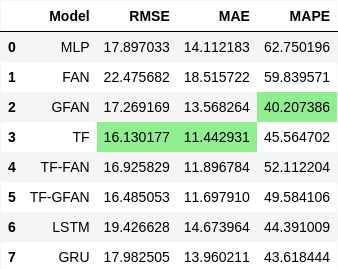

In [47]:
# Exporting and displaying the styled DataFrame
image_data = export_styled_dataframe(
    styled_df=styled_df,
    filename='styled_df.png',
    show_image=True,
    table_conversion='selenium'
)

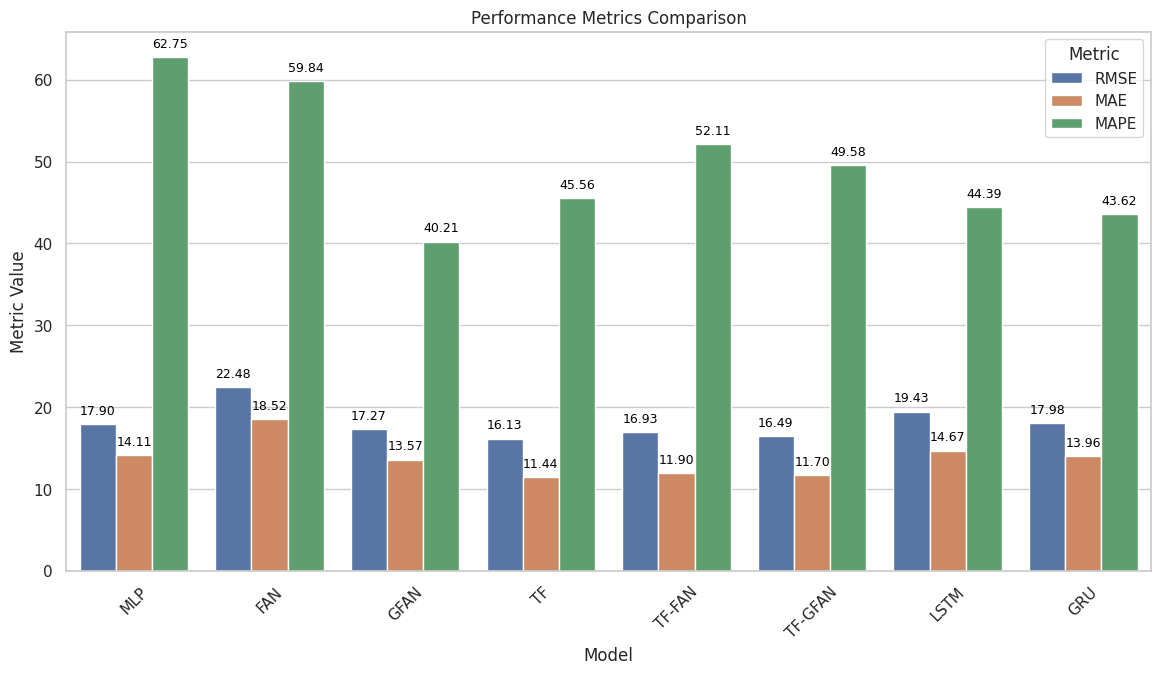

In [48]:
# Plot Performance Metrics
plot_performance_metrics(metrics_df)

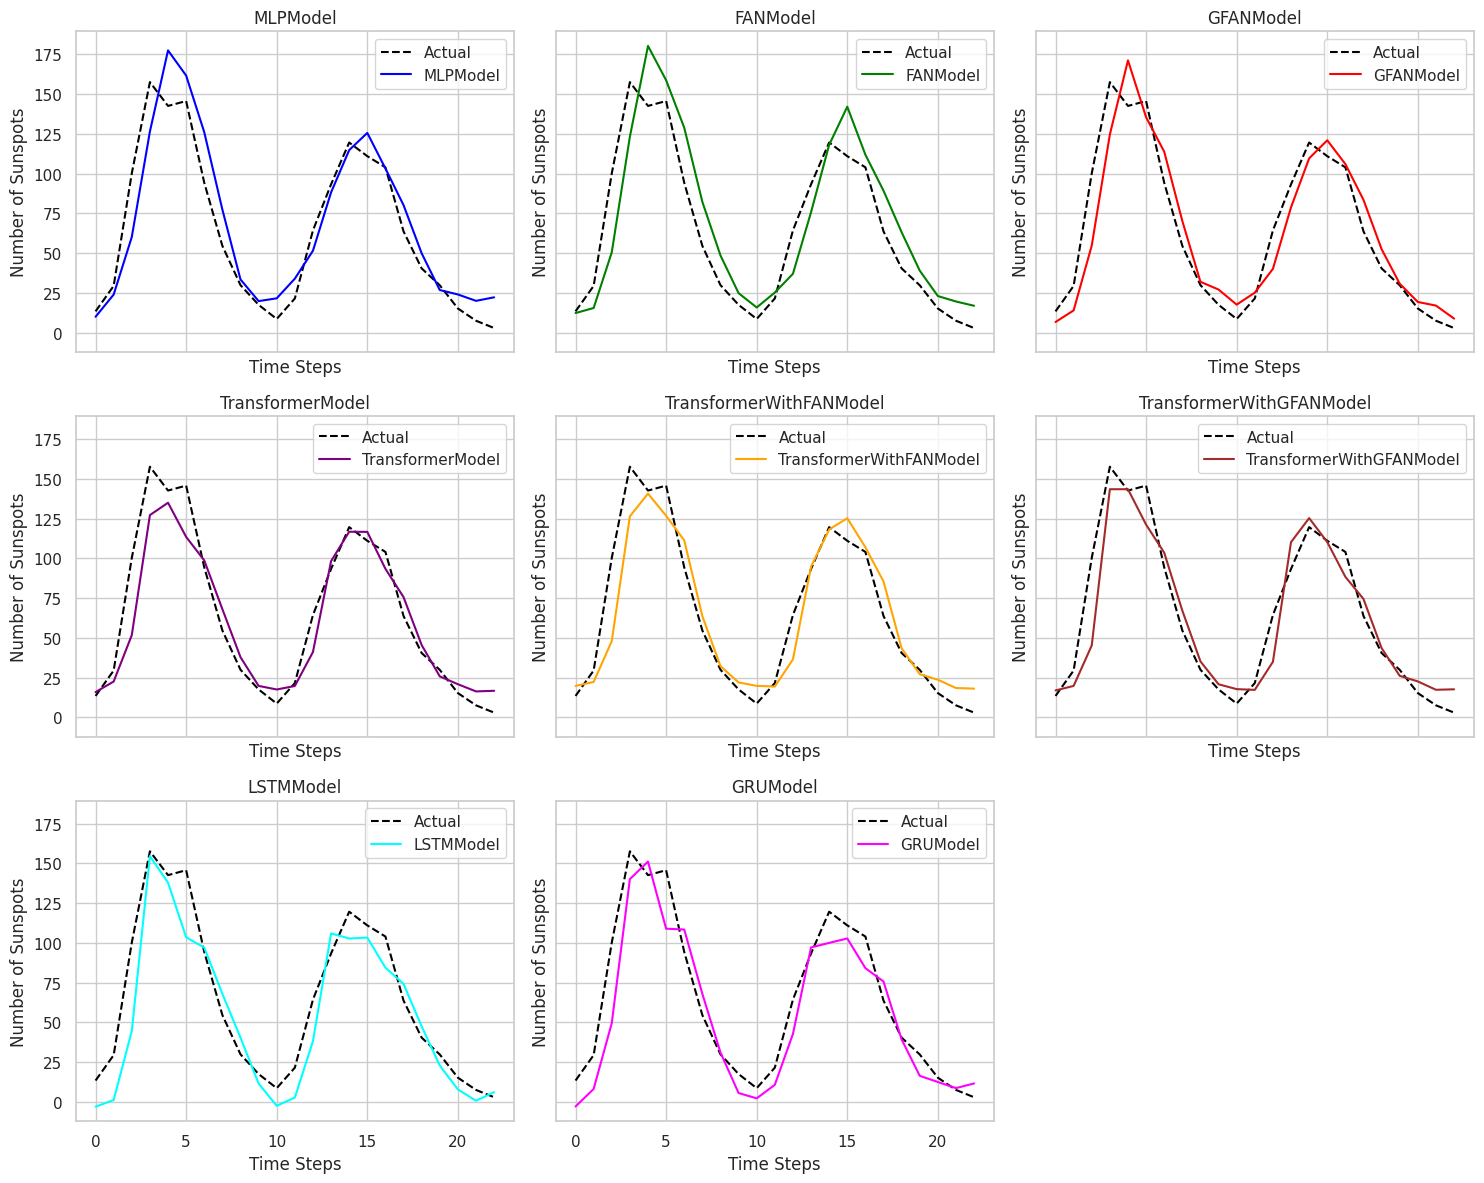

In [49]:
# Plot Predictions vs. Actuals
plot_predictions(performance)